In [2]:
import tensorflow as tf
import numpy as np
import random
import sys
import time
import matplotlib.pyplot as plt

In [3]:
print('TensorFlow version: ', tf.__version__)

TensorFlow version:  2.0.0


In [ ]:
#pip install tensorflow-gpu==2.0.0

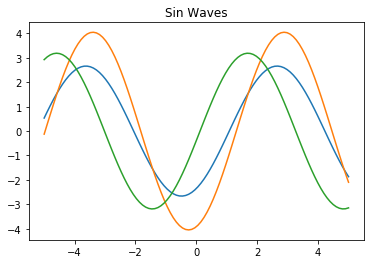

In [4]:
class SineWave():
    '''
    Generate Sine wave
    '''
    def __init__(self, K=10, amplitude=None, phase=None):
        '''
        K = Batch Size which is number of points
        amplitude: amplitude of sine wave
        phase:varies from 0 to pi
        '''
        self.K = K
        self.amplitude = amplitude if amplitude else np.random.uniform(0.1, 5.0)
        self.phase = phase if amplitude else np.random.uniform(0, np.pi)
        self.sampled_points = None
        self.x = self._sample_x()
    def _sample_x(self):
        return np.random.uniform(-5, 5, self.K)
    
    def f(self, x):
        '''
        returns sine wave values
        '''
        return self.amplitude*np.sin(x - self.phase)
    
    def batch(self, x = None, force_new=False):
        '''
        Returns a batch of size K
        Changes the shape of `x` to add a batch dimension to it.
        '''
        if x is None:
            if force_new:
                x = self._sample_x()
            else:
                x = self.x
        y = self.f(x)
        
        return x[:, None], y[:, None]
    
    def equally_spaced_samples(self, K=None):
        '''
        Returns K equally spaces samples
        '''
        if K is None:
            K = self.K
            # -5, 5 : sine wave will be from -5 to 5
        return self.batch(x = np.linspace(-5, 5, K))
    
def plot(data, *args, **kwargs):
    '''
    Plot
    '''
    x, y = data
    return plt.plot(x, y, *args, **kwargs)

for _ in range(3):
    plt.title('Sin Waves')
    K = SineWave(K = 100).equally_spaced_samples()
    plot(K)
plt.show()

# Generate training data set using Sinewave

In [5]:
def generate_dataset(K, training_size=20000, test_size=10):
    '''
    Generate training and test dataset
    
    A dataset is composed of SinusoidGenerators that are 
    able to provide a complete batch elements at a time
    '''
    def _generate_dataset(size):
        return [SineWave(K=K) for _ in range(size)]
    
    return _generate_dataset(training_size), _generate_dataset(test_size)


In [6]:
train_ds, test_ds = generate_dataset(K=10)

## Training a neural net
Train a neural net for a given batch of size K of randomly sampled value (x) and predict f(x) where f is a sine wave with amplitude randomly sampled within [0.1, 5.0] and phase ranomly sampled within [0, $\pi$]

In [77]:
class SineModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        # first hidden layer of size 40
        self.hidden1 = tf.keras.layers.Dense(40, input_shape=(1,), dtype="float64")
        
        # second hidden layer of size 40
        self.hidden2 = tf.keras.layers.Dense(40, dtype="float64")
        
        self.out = tf.keras.layers.Dense(1, dtype="float64")
        
    def forward(self, x):
        x = tf.keras.activations.relu(self.hidden1(x))
        x = tf.keras.activations.relu(self.hidden2(x))
        x = self.out(x)
        return x
        
        

In [78]:
# Loss function
def loss_function(pred_y, y):
    loss_object = tf.keras.losses.mean_squared_error(y, pred_y)
    rms = tf.keras.backend.mean(loss_object)
    return rms


    

In [79]:
def np_to_tensor(list_of_numpy_objs):
    return (tf.convert_to_tensor(obj) for obj in list_of_numpy_objs)

In [80]:
# compute loss
def compute_loss(model, x, y, loss_fn = loss_function):
    logits = model.forward(x)
    mse = loss_fn(y, logits)
    return mse, logits

In [81]:
# compute gradients
def compute_gradients(model, x, y, loss_fn=loss_function):
    with tf.GradientTape() as tape:
        loss, _ = compute_loss(model, x, y, loss_fn)
    return tape.gradient(loss, model.trainable_variables), loss

In [82]:
# apply_gradients
def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

In [83]:
# training batch
def train_batch(x, y, model, optimizer):
    tensor_x, tensor_y = np_to_tensor((x, y))
    gradients, loss = compute_gradients(model, tensor_x, tensor_y)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    return loss



In [84]:
# now training function, log_steps as in not logarithm for printing
# the steps.
def train_model(dataset, epochs=1, lr = 0.001, log_steps=1000):
    model = SineModel()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    for epoch in range(epochs):
        losses = []
        total_loss = 0
        start = time.time()
        for i, sinusoid_generator in enumerate(dataset):
            x, y = sinusoid_generator.batch()
            loss = train_batch(x, y, model, optimizer)
            total_loss +=loss
            average_loss = total_loss/(i+1.0)
            losses.append(average_loss)
            
            if i% log_steps == 0 and i>0:
                print('Step {}: loss = {}, Time = run {} steps = {:.2f} seconds'.format(
                i, average_loss, log_steps, time.time() - start))
                start = time.time()
        plt.plot(losses)
        plt.title('Loss vs time steps')
        plt.show()
    return model

Step 1000: loss = 3.762510717900397, Time = run 1000 steps = 3.79 seconds
Step 2000: loss = 3.464537095710455, Time = run 1000 steps = 3.48 seconds
Step 3000: loss = 3.4354576618060957, Time = run 1000 steps = 3.56 seconds
Step 4000: loss = 3.4267217585145993, Time = run 1000 steps = 3.64 seconds
Step 5000: loss = 3.38026929885051, Time = run 1000 steps = 3.62 seconds
Step 6000: loss = 3.31944702826262, Time = run 1000 steps = 3.40 seconds
Step 7000: loss = 3.277850640384366, Time = run 1000 steps = 3.36 seconds
Step 8000: loss = 3.261731223627305, Time = run 1000 steps = 3.35 seconds
Step 9000: loss = 3.226327923149787, Time = run 1000 steps = 3.35 seconds
Step 10000: loss = 3.2107993315138166, Time = run 1000 steps = 3.35 seconds
Step 11000: loss = 3.2142955976110406, Time = run 1000 steps = 3.35 seconds
Step 12000: loss = 3.1933541619737933, Time = run 1000 steps = 3.35 seconds
Step 13000: loss = 3.1994439402829595, Time = run 1000 steps = 3.32 seconds
Step 14000: loss = 3.205814422

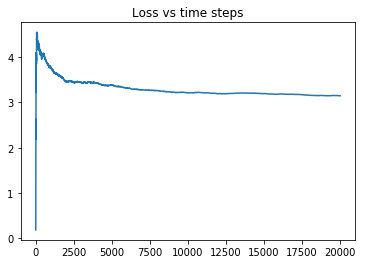

In [85]:
neural_net = train_model(train_ds)

In [86]:
## Comparison: a neural net trained for this task must converge to the average
# of the sinusoid waves
def plot_compare_avg(model, ds, model_name='Neural Network', K=10):
    sin_gen = SineWave(K=K)
    avg_pred = []
    for i, sinusoid_generator in enumerate(ds):
        x, y = sinusoid_generator.equally_spaced_samples()
        avg_pred.append(y)
        
    x, _ = sin_gen.equally_spaced_samples()
    avg_plot, = plt.plot(x, np.mean(avg_pred, axis= 0), '--')
    
    # calculate model prediction
    model_pred = model.forward(tf.convert_to_tensor(x))
    model_plot, = plt.plot(x, model_pred.numpy())
    
    # plot
    plt.legend([avg_plot, model_plot], ['Average', model_name])
    plt.show()

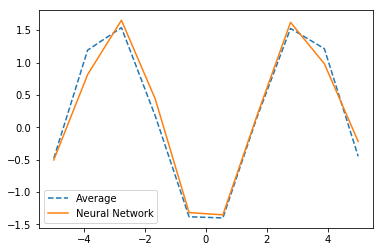

In [87]:
plot_compare_avg(neural_net, train_ds)

In [88]:
# Now comes transfer learning

# Here we try to use the trained neural network to initialize the weights for a model trained on new sine wave functions.

# The new sine wave is treated as a new task. Our model was trained on a bunch of sine wave tasks and we're trying to use this previous knowledge to initialize the weights of the model for a new task.
def copy_model(model, x):
    '''
    Copy model weights to a new model
    Args:
        model: model to be copied
        x: an input example. this is used to run a forward pass in order to add the
        weights of the graph as variables.
        
    returns: a copy model
        
    '''
    
    copied_model = SineModel()
    
    # if we don't run this step, weights will not initialize and gradients won't be computed
    copied_model.forward(tf.convert_to_tensor(x))
    copied_model.set_weights(model.get_weights())
    
    return copied_model

In [89]:

def eval_sine_test(model, optimizer, x, y, x_test, y_test, num_steps=(0,1, 10)):
    '''
    Evaluate how the model fits to the curve training for 'fits' steps
    Args:
        model: mode evaluated
        optimizer: optimizer for the training
        x: data used for training
        y: target used for training
        x_test: data for evaluation
        y_test: target for evaluation
        num_steps: number of steps to log
    '''
    fit_res = []
    
    tensor_x_test, tensor_y_test = np_to_tensor((x_test, y_test))
    # If 0 in fits we log the loss before any training
    if 0 in num_steps:
        loss, logits = compute_loss(model, tensor_x_test, tensor_y_test)
        fit_res.append((0, logits, loss))
        
    for step in range(1, np.max(num_steps) + 1):
        train_batch(x, y, model, optimizer)
        loss, logits = compute_loss(model, tensor_x_test, tensor_y_test)
        if step in num_steps:
            fit_res.append(
                (
                    step, 
                    logits,
                    loss
                )
            )
    return fit_res


In [90]:
def eval_sinewave_for_test(model, sinusoid_generator=None, num_steps=(0, 1, 10), lr=0.01, plot=True):
    '''Evaluates how the sinewave addapts at dataset.
    
    The idea is to use the pretrained model as a weight initializer and
    try to fit the model on this new dataset.
    
    Args:
        model: Already trained model.
        sinusoid_generator: A sinusoidGenerator instance.
        num_steps: Number of training steps to be logged.
        lr: Learning rate used for training on the test data.
        plot: If plot is True than it plots how the curves are fitted along
            `num_steps`.
    
    Returns:
        The fit results. A list containing the loss, logits and step. For
        every step at `num_steps`.
    '''
    
    if sinusoid_generator is None:
        sinusoid_generator = SinusoidGenerator(K=10)
        
    # generate equally spaced samples for ploting
    x_test, y_test = sinusoid_generator.equally_spaced_samples(100)
    
    # batch used for training
    x, y = sinusoid_generator.batch()
    
    # copy model so we can use the same model multiple times
    copied_model = copy_model(model, x)
    
    # use SGD for this part of training as described in the paper
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    
    # run training and log fit results
    fit_res = eval_sine_test(copied_model, optimizer, x, y, x_test, y_test, num_steps)
    
    # plot
    train, = plt.plot(x, y, '^')
    ground_truth, = plt.plot(x_test, y_test)
    plots = [train, ground_truth]
    legend = ['Training Points', 'True Function']
    for n, res, loss in fit_res:
        cur, = plt.plot(x_test, res[:, 0], '--')
        plots.append(cur)
        legend.append(f'After {n} Steps')
    plt.legend(plots, legend)
    plt.ylim(-5, 5)
    plt.xlim(-6, 6)
    if plot:
        plt.show()
    
    return fit_res

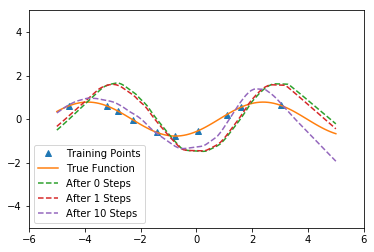

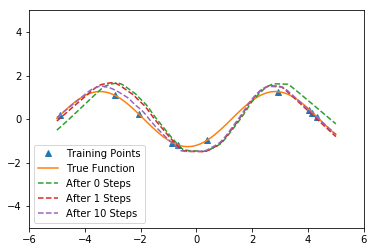

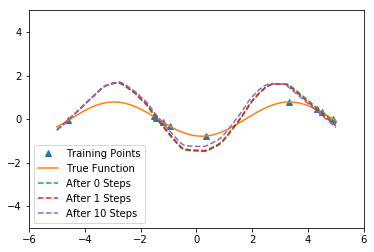

In [91]:
for index in np.random.randint(0, len(test_ds), size=3):
    eval_sinewave_for_test(neural_net, test_ds[index])

## MAML
![](https://cdn-images-1.medium.com/max/1600/1*_pgbRGIlmCRsYNBHl71mUA.png)

In [95]:
def train_maml(model, epochs, dataset, lr_inner=0.01, batch_size=1, log_steps=1000):
    '''Train using the MAML setup.
    
    The comments in this function that start with:
        
        Step X:
        
    Refer to a step described in the Algorithm 1 of the paper.
    
    Args:
        model: A model.
        epochs: Number of epochs used for training.
        dataset: A dataset used for training.
        lr_inner: Inner learning rate (alpha in Algorithm 1). Default value is 0.01.
        batch_size: Batch size. Default value is 1. The paper does not specify
            which value they use.
        log_steps: At every `log_steps` a log message is printed.
    
    Returns:
        A strong, fully-developed and trained maml.
    '''
    optimizer = tf.keras.optimizers.Adam()
    
    # Step 2: instead of checking for convergence, we train for a number
    # of epochs
    for _ in range(epochs):
        total_loss = 0
        losses = []
        start = time.time()
        # Step 3 and 4
        for i, t in enumerate(random.sample(dataset, len(dataset))):
            print('i = {}, t = {}'.format(i, t))
            x, y = np_to_tensor(t.batch())
            model.forward(x)  # run forward pass to initialize weights
            with tf.GradientTape() as test_tape:
                # test_tape.watch(model.trainable_variables)
                # Step 5
                with tf.GradientTape() as train_tape:
                    train_loss, _ = compute_loss(model, x, y)
                # Step 6
                gradients = train_tape.gradient(train_loss, model.trainable_variables)
                k = 0
                model_copy = copy_model(model, x)
                for j in range(len(model_copy.layers)):
                    model_copy.layers[j].kernel = tf.subtract(model.layers[j].kernel,
                                tf.multiply(lr_inner, gradients[k]))
                    model_copy.layers[j].bias = tf.subtract(model.layers[j].bias,
                                tf.multiply(lr_inner, gradients[k+1]))
                    k += 2
                # Step 8
                test_loss, logits = compute_loss(model_copy, x, y)
            # Step 8
            gradients = test_tape.gradient(test_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            # Logs
            total_loss += test_loss
            loss = total_loss / (i+1.0)
            losses.append(loss)
            
            if i % log_steps == 0 and i > 0:
                print('Step {}: loss = {}, Time to run {} steps = {}'.format(i, loss, log_steps, time.time() - start))
                start = time.time()
        plt.plot(losses)
        plt.show()

i = 0, t = <__main__.SineWave object at 0x7feafc9d8358>
i = 1, t = <__main__.SineWave object at 0x7feafc9c2cf8>
i = 2, t = <__main__.SineWave object at 0x7feafc79f160>
i = 3, t = <__main__.SineWave object at 0x7feafc9477f0>
i = 4, t = <__main__.SineWave object at 0x7feafc570630>
i = 5, t = <__main__.SineWave object at 0x7feafca2ebe0>
i = 6, t = <__main__.SineWave object at 0x7feafc71eb00>
i = 7, t = <__main__.SineWave object at 0x7feafc845a20>
i = 8, t = <__main__.SineWave object at 0x7feafc86bda0>
i = 9, t = <__main__.SineWave object at 0x7feafc754748>
i = 10, t = <__main__.SineWave object at 0x7feafc536438>
i = 11, t = <__main__.SineWave object at 0x7feafc626e10>
i = 12, t = <__main__.SineWave object at 0x7feafc8c6358>
i = 13, t = <__main__.SineWave object at 0x7feafc6e36a0>
i = 14, t = <__main__.SineWave object at 0x7feafc6f2e48>
i = 15, t = <__main__.SineWave object at 0x7feafc7afcc0>
i = 16, t = <__main__.SineWave object at 0x7feafc8eb0f0>
i = 17, t = <__main__.SineWave object at 

i = 151, t = <__main__.SineWave object at 0x7feafc83a208>
i = 152, t = <__main__.SineWave object at 0x7feafc9ee908>
i = 153, t = <__main__.SineWave object at 0x7feafc9987f0>
i = 154, t = <__main__.SineWave object at 0x7feafc5560b8>
i = 155, t = <__main__.SineWave object at 0x7feafc8978d0>
i = 156, t = <__main__.SineWave object at 0x7feafc652f28>
i = 157, t = <__main__.SineWave object at 0x7feafc5cb780>
i = 158, t = <__main__.SineWave object at 0x7feafc4ff668>
i = 159, t = <__main__.SineWave object at 0x7feafc9de208>
i = 160, t = <__main__.SineWave object at 0x7feafc769630>
i = 161, t = <__main__.SineWave object at 0x7feafc51a5f8>
i = 162, t = <__main__.SineWave object at 0x7feafc5dbf28>
i = 163, t = <__main__.SineWave object at 0x7feafc6523c8>
i = 164, t = <__main__.SineWave object at 0x7feafc89c438>
i = 165, t = <__main__.SineWave object at 0x7feafc6e3c18>
i = 166, t = <__main__.SineWave object at 0x7feafc7d4898>
i = 167, t = <__main__.SineWave object at 0x7feafc728048>
i = 168, t = <

i = 293, t = <__main__.SineWave object at 0x7feafc5e6198>
i = 294, t = <__main__.SineWave object at 0x7feafc657eb8>
i = 295, t = <__main__.SineWave object at 0x7feafc70ea20>
i = 296, t = <__main__.SineWave object at 0x7feafc84b978>
i = 297, t = <__main__.SineWave object at 0x7feafc8fb400>
i = 298, t = <__main__.SineWave object at 0x7feafc8cc6a0>
i = 299, t = <__main__.SineWave object at 0x7feafc66c278>
i = 300, t = <__main__.SineWave object at 0x7feafc4809b0>
i = 301, t = <__main__.SineWave object at 0x7feafc6c3e80>
i = 302, t = <__main__.SineWave object at 0x7feafc79fcc0>
i = 303, t = <__main__.SineWave object at 0x7feafc51aef0>
i = 304, t = <__main__.SineWave object at 0x7feafc677f28>
i = 305, t = <__main__.SineWave object at 0x7feafc82fb00>
i = 306, t = <__main__.SineWave object at 0x7feafc709748>
i = 307, t = <__main__.SineWave object at 0x7feafc779710>
i = 308, t = <__main__.SineWave object at 0x7feafc6064e0>
i = 309, t = <__main__.SineWave object at 0x7feafc5755c0>
i = 310, t = <

i = 437, t = <__main__.SineWave object at 0x7feafc9479b0>
i = 438, t = <__main__.SineWave object at 0x7feafc565898>
i = 439, t = <__main__.SineWave object at 0x7feafc97c898>
i = 440, t = <__main__.SineWave object at 0x7feafc8bc2b0>
i = 441, t = <__main__.SineWave object at 0x7feafc6f2588>
i = 442, t = <__main__.SineWave object at 0x7feafc845080>
i = 443, t = <__main__.SineWave object at 0x7feafc8614a8>
i = 444, t = <__main__.SineWave object at 0x7feafc91b4a8>
i = 445, t = <__main__.SineWave object at 0x7feafc86bf98>
i = 446, t = <__main__.SineWave object at 0x7feafc91b5c0>
i = 447, t = <__main__.SineWave object at 0x7feafc91bc18>
i = 448, t = <__main__.SineWave object at 0x7feafc6f9a58>
i = 449, t = <__main__.SineWave object at 0x7feafc94d0b8>
i = 450, t = <__main__.SineWave object at 0x7feafc7b3358>
i = 451, t = <__main__.SineWave object at 0x7feafca33400>
i = 452, t = <__main__.SineWave object at 0x7feafc5c6048>
i = 453, t = <__main__.SineWave object at 0x7feafc738080>
i = 454, t = <

i = 580, t = <__main__.SineWave object at 0x7feafc515d30>
i = 581, t = <__main__.SineWave object at 0x7feafc80a080>
i = 582, t = <__main__.SineWave object at 0x7feafc861eb8>
i = 583, t = <__main__.SineWave object at 0x7feafc6ddb70>
i = 584, t = <__main__.SineWave object at 0x7feafc8b5518>
i = 585, t = <__main__.SineWave object at 0x7feafc7b9b38>
i = 586, t = <__main__.SineWave object at 0x7feafc62c7f0>
i = 587, t = <__main__.SineWave object at 0x7feafc875cf8>
i = 588, t = <__main__.SineWave object at 0x7feafc84bbe0>
i = 589, t = <__main__.SineWave object at 0x7feafc601a20>
i = 590, t = <__main__.SineWave object at 0x7feafc4bf630>
i = 591, t = <__main__.SineWave object at 0x7feafc779470>
i = 592, t = <__main__.SineWave object at 0x7feafc9d8c50>
i = 593, t = <__main__.SineWave object at 0x7feafc850438>
i = 594, t = <__main__.SineWave object at 0x7feafc769eb8>
i = 595, t = <__main__.SineWave object at 0x7feafc636eb8>
i = 596, t = <__main__.SineWave object at 0x7feafca1deb8>
i = 597, t = <

i = 722, t = <__main__.SineWave object at 0x7feafc4f9cc0>
i = 723, t = <__main__.SineWave object at 0x7feafc8dc0f0>
i = 724, t = <__main__.SineWave object at 0x7feafc7645c0>
i = 725, t = <__main__.SineWave object at 0x7feafc6d8588>
i = 726, t = <__main__.SineWave object at 0x7feafc6b2278>
i = 727, t = <__main__.SineWave object at 0x7feafc870208>
i = 728, t = <__main__.SineWave object at 0x7feafc5c12e8>
i = 729, t = <__main__.SineWave object at 0x7feafc53ad68>
i = 730, t = <__main__.SineWave object at 0x7feafc73fd30>
i = 731, t = <__main__.SineWave object at 0x7feafc890780>
i = 732, t = <__main__.SineWave object at 0x7feafc4c9518>
i = 733, t = <__main__.SineWave object at 0x7feafc9fd828>
i = 734, t = <__main__.SineWave object at 0x7feafc5f64e0>
i = 735, t = <__main__.SineWave object at 0x7feafc8ebbe0>
i = 736, t = <__main__.SineWave object at 0x7feafc6bcbe0>
i = 737, t = <__main__.SineWave object at 0x7feafc556d68>
i = 738, t = <__main__.SineWave object at 0x7feafd53c860>
i = 739, t = <

i = 873, t = <__main__.SineWave object at 0x7feafc5e1630>
i = 874, t = <__main__.SineWave object at 0x7feafc976048>
i = 875, t = <__main__.SineWave object at 0x7feafca78278>
i = 876, t = <__main__.SineWave object at 0x7feafc6d3748>
i = 877, t = <__main__.SineWave object at 0x7feafc98d710>
i = 878, t = <__main__.SineWave object at 0x7feafc56bfd0>
i = 879, t = <__main__.SineWave object at 0x7feafc9bddd8>
i = 880, t = <__main__.SineWave object at 0x7feafc6c89b0>
i = 881, t = <__main__.SineWave object at 0x7feafc4ea780>
i = 882, t = <__main__.SineWave object at 0x7feafc71ec18>
i = 883, t = <__main__.SineWave object at 0x7feafc78a518>
i = 884, t = <__main__.SineWave object at 0x7feafc72e518>
i = 885, t = <__main__.SineWave object at 0x7feafc76e898>
i = 886, t = <__main__.SineWave object at 0x7feafc546940>
i = 887, t = <__main__.SineWave object at 0x7feafc810eb8>
i = 888, t = <__main__.SineWave object at 0x7feafc4c9358>
i = 889, t = <__main__.SineWave object at 0x7feafc48a940>
i = 890, t = <

i = 1016, t = <__main__.SineWave object at 0x7feafc7f5ac8>
i = 1017, t = <__main__.SineWave object at 0x7feafc8e6080>
i = 1018, t = <__main__.SineWave object at 0x7feafc64dc18>
i = 1019, t = <__main__.SineWave object at 0x7feafc917be0>
i = 1020, t = <__main__.SineWave object at 0x7feafca29198>
i = 1021, t = <__main__.SineWave object at 0x7feafc749dd8>
i = 1022, t = <__main__.SineWave object at 0x7feafc68dcf8>
i = 1023, t = <__main__.SineWave object at 0x7feafc855828>
i = 1024, t = <__main__.SineWave object at 0x7feafc870278>
i = 1025, t = <__main__.SineWave object at 0x7feafc6ad7f0>
i = 1026, t = <__main__.SineWave object at 0x7feafc942400>
i = 1027, t = <__main__.SineWave object at 0x7feafc82b320>
i = 1028, t = <__main__.SineWave object at 0x7feafc7c4940>
i = 1029, t = <__main__.SineWave object at 0x7feafc510208>
i = 1030, t = <__main__.SineWave object at 0x7feafc9bdda0>
i = 1031, t = <__main__.SineWave object at 0x7feafca18908>
i = 1032, t = <__main__.SineWave object at 0x7feafc983d3

i = 1155, t = <__main__.SineWave object at 0x7feafc550da0>
i = 1156, t = <__main__.SineWave object at 0x7feafc9ce630>
i = 1157, t = <__main__.SineWave object at 0x7feafc8e6780>
i = 1158, t = <__main__.SineWave object at 0x7feafc586a58>
i = 1159, t = <__main__.SineWave object at 0x7feafc480e80>
i = 1160, t = <__main__.SineWave object at 0x7feafc9d8d68>
i = 1161, t = <__main__.SineWave object at 0x7feafc9e7c50>
i = 1162, t = <__main__.SineWave object at 0x7feafc81f9b0>
i = 1163, t = <__main__.SineWave object at 0x7feafc575518>
i = 1164, t = <__main__.SineWave object at 0x7feafc84bc50>
i = 1165, t = <__main__.SineWave object at 0x7feafc861c50>
i = 1166, t = <__main__.SineWave object at 0x7feafca1d588>
i = 1167, t = <__main__.SineWave object at 0x7feafc6065c0>
i = 1168, t = <__main__.SineWave object at 0x7feafc947e10>
i = 1169, t = <__main__.SineWave object at 0x7feafc6dd550>
i = 1170, t = <__main__.SineWave object at 0x7feafc70e320>
i = 1171, t = <__main__.SineWave object at 0x7feafc9c947

i = 1300, t = <__main__.SineWave object at 0x7feafc682ba8>
i = 1301, t = <__main__.SineWave object at 0x7feafc5e1fd0>
i = 1302, t = <__main__.SineWave object at 0x7feafc570518>
i = 1303, t = <__main__.SineWave object at 0x7feafc7337b8>
i = 1304, t = <__main__.SineWave object at 0x7feafc682a90>
i = 1305, t = <__main__.SineWave object at 0x7feafca29630>
i = 1306, t = <__main__.SineWave object at 0x7feafc8c0860>
i = 1307, t = <__main__.SineWave object at 0x7feafc8b0780>
i = 1308, t = <__main__.SineWave object at 0x7feafc6e82e8>
i = 1309, t = <__main__.SineWave object at 0x7feafc6c3da0>
i = 1310, t = <__main__.SineWave object at 0x7feafc9c9b00>
i = 1311, t = <__main__.SineWave object at 0x7feafc5f6160>
i = 1312, t = <__main__.SineWave object at 0x7feafc90c710>
i = 1313, t = <__main__.SineWave object at 0x7feafc586128>
i = 1314, t = <__main__.SineWave object at 0x7feafc4c5c88>
i = 1315, t = <__main__.SineWave object at 0x7feafca78b00>
i = 1316, t = <__main__.SineWave object at 0x7feafc84586

i = 1446, t = <__main__.SineWave object at 0x7feafc6d8eb8>
i = 1447, t = <__main__.SineWave object at 0x7feafc6edc88>
i = 1448, t = <__main__.SineWave object at 0x7feafc5a1c50>
i = 1449, t = <__main__.SineWave object at 0x7feafc69e6d8>
i = 1450, t = <__main__.SineWave object at 0x7feafc7e5c88>
i = 1451, t = <__main__.SineWave object at 0x7feafc9e77f0>
i = 1452, t = <__main__.SineWave object at 0x7feafc7c9eb8>
i = 1453, t = <__main__.SineWave object at 0x7feafc9c9780>
i = 1454, t = <__main__.SineWave object at 0x7feafc8bc898>
i = 1455, t = <__main__.SineWave object at 0x7feafc6c3550>
i = 1456, t = <__main__.SineWave object at 0x7feafc855898>
i = 1457, t = <__main__.SineWave object at 0x7feafc9bd208>
i = 1458, t = <__main__.SineWave object at 0x7feafca6e7f0>
i = 1459, t = <__main__.SineWave object at 0x7feafc5f6470>
i = 1460, t = <__main__.SineWave object at 0x7feafc92d4a8>
i = 1461, t = <__main__.SineWave object at 0x7feafc6ed9e8>
i = 1462, t = <__main__.SineWave object at 0x7feafc8dc2b

i = 1591, t = <__main__.SineWave object at 0x7feafc8ab978>
i = 1592, t = <__main__.SineWave object at 0x7feafc886630>
i = 1593, t = <__main__.SineWave object at 0x7feafc48a240>
i = 1594, t = <__main__.SineWave object at 0x7feafc50a390>
i = 1595, t = <__main__.SineWave object at 0x7feafc65c8d0>
i = 1596, t = <__main__.SineWave object at 0x7feafc7ff550>
i = 1597, t = <__main__.SineWave object at 0x7feafc9ac128>
i = 1598, t = <__main__.SineWave object at 0x7feafc73feb8>
i = 1599, t = <__main__.SineWave object at 0x7feafc8a03c8>
i = 1600, t = <__main__.SineWave object at 0x7feafc9f3c18>
i = 1601, t = <__main__.SineWave object at 0x7feafc8fb518>
i = 1602, t = <__main__.SineWave object at 0x7feafca733c8>
i = 1603, t = <__main__.SineWave object at 0x7feafc5ebfd0>
i = 1604, t = <__main__.SineWave object at 0x7feafc575a20>
i = 1605, t = <__main__.SineWave object at 0x7feafc4ee2b0>
i = 1606, t = <__main__.SineWave object at 0x7feafca786a0>
i = 1607, t = <__main__.SineWave object at 0x7feafc88b58

i = 1737, t = <__main__.SineWave object at 0x7feafc5e17f0>
i = 1738, t = <__main__.SineWave object at 0x7feafc66c0f0>
i = 1739, t = <__main__.SineWave object at 0x7feafc890518>
i = 1740, t = <__main__.SineWave object at 0x7feafc6fd080>
i = 1741, t = <__main__.SineWave object at 0x7feafc8708d0>
i = 1742, t = <__main__.SineWave object at 0x7feafc93cb38>
i = 1743, t = <__main__.SineWave object at 0x7feafc606eb8>
i = 1744, t = <__main__.SineWave object at 0x7feafc9d3d68>
i = 1745, t = <__main__.SineWave object at 0x7feafc510c50>
i = 1746, t = <__main__.SineWave object at 0x7feafc908da0>
i = 1747, t = <__main__.SineWave object at 0x7feafc8a0ef0>
i = 1748, t = <__main__.SineWave object at 0x7feafc96c828>
i = 1749, t = <__main__.SineWave object at 0x7feafca69cc0>
i = 1750, t = <__main__.SineWave object at 0x7feafc972ba8>
i = 1751, t = <__main__.SineWave object at 0x7feafc850b70>
i = 1752, t = <__main__.SineWave object at 0x7feafc7f9cf8>
i = 1753, t = <__main__.SineWave object at 0x7feafc7b3f9

i = 1881, t = <__main__.SineWave object at 0x7feafc8e1278>
i = 1882, t = <__main__.SineWave object at 0x7feafc4f4748>
i = 1883, t = <__main__.SineWave object at 0x7feafc744ef0>
i = 1884, t = <__main__.SineWave object at 0x7feafc688a20>
i = 1885, t = <__main__.SineWave object at 0x7feafc6616d8>
i = 1886, t = <__main__.SineWave object at 0x7feafca38da0>
i = 1887, t = <__main__.SineWave object at 0x7feafc536518>
i = 1888, t = <__main__.SineWave object at 0x7feafc908f60>
i = 1889, t = <__main__.SineWave object at 0x7feafc7c0d30>
i = 1890, t = <__main__.SineWave object at 0x7feafc7c47f0>
i = 1891, t = <__main__.SineWave object at 0x7feafc9675f8>
i = 1892, t = <__main__.SineWave object at 0x7feafc6e8400>
i = 1893, t = <__main__.SineWave object at 0x7feafc97cc18>
i = 1894, t = <__main__.SineWave object at 0x7feafc72e400>
i = 1895, t = <__main__.SineWave object at 0x7feafc520e80>
i = 1896, t = <__main__.SineWave object at 0x7feafc6c8550>
i = 1897, t = <__main__.SineWave object at 0x7feafc794a9

i = 2024, t = <__main__.SineWave object at 0x7feafc850978>
i = 2025, t = <__main__.SineWave object at 0x7feafc7f50f0>
i = 2026, t = <__main__.SineWave object at 0x7feafc8d6908>
i = 2027, t = <__main__.SineWave object at 0x7feafc8ab828>
i = 2028, t = <__main__.SineWave object at 0x7feafc590c50>
i = 2029, t = <__main__.SineWave object at 0x7feafc78a908>
i = 2030, t = <__main__.SineWave object at 0x7feafc77fcc0>
i = 2031, t = <__main__.SineWave object at 0x7feafc6015c0>
i = 2032, t = <__main__.SineWave object at 0x7feafc550898>
i = 2033, t = <__main__.SineWave object at 0x7feafc89c6d8>
i = 2034, t = <__main__.SineWave object at 0x7feafc586cf8>
i = 2035, t = <__main__.SineWave object at 0x7feafc8a64a8>
i = 2036, t = <__main__.SineWave object at 0x7feafca1d0b8>
i = 2037, t = <__main__.SineWave object at 0x7feafc5c1240>
i = 2038, t = <__main__.SineWave object at 0x7feafc68d908>
i = 2039, t = <__main__.SineWave object at 0x7feafc758e10>
i = 2040, t = <__main__.SineWave object at 0x7feafc9bd82

i = 2168, t = <__main__.SineWave object at 0x7feafc672198>
i = 2169, t = <__main__.SineWave object at 0x7feafc8a6978>
i = 2170, t = <__main__.SineWave object at 0x7feafc4dbcc0>
i = 2171, t = <__main__.SineWave object at 0x7feafc82bef0>
i = 2172, t = <__main__.SineWave object at 0x7feafc52fdd8>
i = 2173, t = <__main__.SineWave object at 0x7feafc927da0>
i = 2174, t = <__main__.SineWave object at 0x7feafc7099b0>
i = 2175, t = <__main__.SineWave object at 0x7feafc4f41d0>
i = 2176, t = <__main__.SineWave object at 0x7feafc9eecc0>
i = 2177, t = <__main__.SineWave object at 0x7feafc9e20f0>
i = 2178, t = <__main__.SineWave object at 0x7feafc5ebf60>
i = 2179, t = <__main__.SineWave object at 0x7feafc575e10>
i = 2180, t = <__main__.SineWave object at 0x7feafc4f9630>
i = 2181, t = <__main__.SineWave object at 0x7feafc85a630>
i = 2182, t = <__main__.SineWave object at 0x7feafc9ee748>
i = 2183, t = <__main__.SineWave object at 0x7feafc7da358>
i = 2184, t = <__main__.SineWave object at 0x7feafc510ba

i = 2312, t = <__main__.SineWave object at 0x7feafc810be0>
i = 2313, t = <__main__.SineWave object at 0x7feafc9373c8>
i = 2314, t = <__main__.SineWave object at 0x7feafc4d4d30>
i = 2315, t = <__main__.SineWave object at 0x7feafc480160>
i = 2316, t = <__main__.SineWave object at 0x7feafc9bd5c0>
i = 2317, t = <__main__.SineWave object at 0x7feafc71eb38>
i = 2318, t = <__main__.SineWave object at 0x7feafc9f3b70>
i = 2319, t = <__main__.SineWave object at 0x7feafca1d080>
i = 2320, t = <__main__.SineWave object at 0x7feafc9126d8>
i = 2321, t = <__main__.SineWave object at 0x7feafc7a4198>
i = 2322, t = <__main__.SineWave object at 0x7feafc5a1f98>
i = 2323, t = <__main__.SineWave object at 0x7feafc7dfdd8>
i = 2324, t = <__main__.SineWave object at 0x7feafca234a8>
i = 2325, t = <__main__.SineWave object at 0x7feafc621358>
i = 2326, t = <__main__.SineWave object at 0x7feafc8b58d0>
i = 2327, t = <__main__.SineWave object at 0x7feafc8ab710>
i = 2328, t = <__main__.SineWave object at 0x7feafc8d26d

i = 2454, t = <__main__.SineWave object at 0x7feafc5d7048>
i = 2455, t = <__main__.SineWave object at 0x7feafc590668>
i = 2456, t = <__main__.SineWave object at 0x7feafca133c8>
i = 2457, t = <__main__.SineWave object at 0x7feafc5ab470>
i = 2458, t = <__main__.SineWave object at 0x7feafca13cc0>
i = 2459, t = <__main__.SineWave object at 0x7feafc9d34a8>
i = 2460, t = <__main__.SineWave object at 0x7feafc5d13c8>
i = 2461, t = <__main__.SineWave object at 0x7feafc4dfeb8>
i = 2462, t = <__main__.SineWave object at 0x7feafc53a4e0>
i = 2463, t = <__main__.SineWave object at 0x7feafc8f7c50>
i = 2464, t = <__main__.SineWave object at 0x7feafc841198>
i = 2465, t = <__main__.SineWave object at 0x7feafc9e26a0>
i = 2466, t = <__main__.SineWave object at 0x7feafc95d978>
i = 2467, t = <__main__.SineWave object at 0x7feafc9b8eb8>
i = 2468, t = <__main__.SineWave object at 0x7feafc9fda20>
i = 2469, t = <__main__.SineWave object at 0x7feafc79a908>
i = 2470, t = <__main__.SineWave object at 0x7feafc647a2

i = 2594, t = <__main__.SineWave object at 0x7feafc9fda90>
i = 2595, t = <__main__.SineWave object at 0x7feafc632470>
i = 2596, t = <__main__.SineWave object at 0x7feafc79a160>
i = 2597, t = <__main__.SineWave object at 0x7feafc4d4a58>
i = 2598, t = <__main__.SineWave object at 0x7feafc967c18>
i = 2599, t = <__main__.SineWave object at 0x7feafc8c6390>
i = 2600, t = <__main__.SineWave object at 0x7feafc4ea7f0>
i = 2601, t = <__main__.SineWave object at 0x7feafc7e9f98>
i = 2602, t = <__main__.SineWave object at 0x7feafc87a588>
i = 2603, t = <__main__.SineWave object at 0x7feafc4d4748>
i = 2604, t = <__main__.SineWave object at 0x7feafc824dd8>
i = 2605, t = <__main__.SineWave object at 0x7feafc7d03c8>
i = 2606, t = <__main__.SineWave object at 0x7feafc6b79e8>
i = 2607, t = <__main__.SineWave object at 0x7feafc9f3128>
i = 2608, t = <__main__.SineWave object at 0x7feafc5abef0>
i = 2609, t = <__main__.SineWave object at 0x7feafc6b26a0>
i = 2610, t = <__main__.SineWave object at 0x7feafc7d424

i = 2735, t = <__main__.SineWave object at 0x7feafc4d40f0>
i = 2736, t = <__main__.SineWave object at 0x7feafc4dbf98>
i = 2737, t = <__main__.SineWave object at 0x7feafc82b588>
i = 2738, t = <__main__.SineWave object at 0x7feafc8a6c18>
i = 2739, t = <__main__.SineWave object at 0x7feafc951080>
i = 2740, t = <__main__.SineWave object at 0x7feafc810828>
i = 2741, t = <__main__.SineWave object at 0x7feafc9274a8>
i = 2742, t = <__main__.SineWave object at 0x7feafc815470>
i = 2743, t = <__main__.SineWave object at 0x7feafc7237f0>
i = 2744, t = <__main__.SineWave object at 0x7feafca13860>
i = 2745, t = <__main__.SineWave object at 0x7feafca73358>
i = 2746, t = <__main__.SineWave object at 0x7feafc99d0f0>
i = 2747, t = <__main__.SineWave object at 0x7feafc8c64a8>
i = 2748, t = <__main__.SineWave object at 0x7feafc78e470>
i = 2749, t = <__main__.SineWave object at 0x7feafc963240>
i = 2750, t = <__main__.SineWave object at 0x7feafc5ba390>
i = 2751, t = <__main__.SineWave object at 0x7feafc9d3c8

i = 2877, t = <__main__.SineWave object at 0x7feafc80a6a0>
i = 2878, t = <__main__.SineWave object at 0x7feafc81f7b8>
i = 2879, t = <__main__.SineWave object at 0x7feafc6c3908>
i = 2880, t = <__main__.SineWave object at 0x7feafc8d2d30>
i = 2881, t = <__main__.SineWave object at 0x7feafc9c90f0>
i = 2882, t = <__main__.SineWave object at 0x7feafc81ba20>
i = 2883, t = <__main__.SineWave object at 0x7feafc5c60b8>
i = 2884, t = <__main__.SineWave object at 0x7feafc9f3d30>
i = 2885, t = <__main__.SineWave object at 0x7feafc8f1dd8>
i = 2886, t = <__main__.SineWave object at 0x7feafc6d85f8>
i = 2887, t = <__main__.SineWave object at 0x7feafc5c1438>
i = 2888, t = <__main__.SineWave object at 0x7feafc908a20>
i = 2889, t = <__main__.SineWave object at 0x7feafc9eeb70>
i = 2890, t = <__main__.SineWave object at 0x7feafc8c0dd8>
i = 2891, t = <__main__.SineWave object at 0x7feafc9ac8d0>
i = 2892, t = <__main__.SineWave object at 0x7feafc56bc50>
i = 2893, t = <__main__.SineWave object at 0x7feafc5ebc8

i = 3015, t = <__main__.SineWave object at 0x7feafc611390>
i = 3016, t = <__main__.SineWave object at 0x7feafc55fa20>
i = 3017, t = <__main__.SineWave object at 0x7feafc64d9b0>
i = 3018, t = <__main__.SineWave object at 0x7feafc7e9f60>
i = 3019, t = <__main__.SineWave object at 0x7feafc52a4e0>
i = 3020, t = <__main__.SineWave object at 0x7feafc9ee668>
i = 3021, t = <__main__.SineWave object at 0x7feafc647da0>
i = 3022, t = <__main__.SineWave object at 0x7feafc8b56d8>
i = 3023, t = <__main__.SineWave object at 0x7feafc6f9780>
i = 3024, t = <__main__.SineWave object at 0x7feafc92d908>
i = 3025, t = <__main__.SineWave object at 0x7feafc703b70>
i = 3026, t = <__main__.SineWave object at 0x7feafc6921d0>
i = 3027, t = <__main__.SineWave object at 0x7feafc70e438>
i = 3028, t = <__main__.SineWave object at 0x7feafc5750b8>
i = 3029, t = <__main__.SineWave object at 0x7feafc82b668>
i = 3030, t = <__main__.SineWave object at 0x7feafc632400>
i = 3031, t = <__main__.SineWave object at 0x7feafc976a9

i = 3157, t = <__main__.SineWave object at 0x7feafc998eb8>
i = 3158, t = <__main__.SineWave object at 0x7feafc52f470>
i = 3159, t = <__main__.SineWave object at 0x7feafc719ba8>
i = 3160, t = <__main__.SineWave object at 0x7feafc636b70>
i = 3161, t = <__main__.SineWave object at 0x7feafc575fd0>
i = 3162, t = <__main__.SineWave object at 0x7feafc90c518>
i = 3163, t = <__main__.SineWave object at 0x7feafc668748>
i = 3164, t = <__main__.SineWave object at 0x7feafc668cc0>
i = 3165, t = <__main__.SineWave object at 0x7feafc9e2be0>
i = 3166, t = <__main__.SineWave object at 0x7feafc8a61d0>
i = 3167, t = <__main__.SineWave object at 0x7feafc749080>
i = 3168, t = <__main__.SineWave object at 0x7feafc4fff98>
i = 3169, t = <__main__.SineWave object at 0x7feafc9874a8>
i = 3170, t = <__main__.SineWave object at 0x7feafc8d2f60>
i = 3171, t = <__main__.SineWave object at 0x7feafc79aac8>
i = 3172, t = <__main__.SineWave object at 0x7feafc510ac8>
i = 3173, t = <__main__.SineWave object at 0x7feafc69e24

i = 3296, t = <__main__.SineWave object at 0x7feafc8d6400>
i = 3297, t = <__main__.SineWave object at 0x7feafc5ab400>
i = 3298, t = <__main__.SineWave object at 0x7feafc575160>
i = 3299, t = <__main__.SineWave object at 0x7feafc9bd438>
i = 3300, t = <__main__.SineWave object at 0x7feafc7b96d8>
i = 3301, t = <__main__.SineWave object at 0x7feafc8d26a0>
i = 3302, t = <__main__.SineWave object at 0x7feafc6a8898>
i = 3303, t = <__main__.SineWave object at 0x7feafc5bae80>
i = 3304, t = <__main__.SineWave object at 0x7feafc581710>
i = 3305, t = <__main__.SineWave object at 0x7feafc7139b0>
i = 3306, t = <__main__.SineWave object at 0x7feafc6b7278>
i = 3307, t = <__main__.SineWave object at 0x7feafc92ddd8>
i = 3308, t = <__main__.SineWave object at 0x7feafc5d1c18>
i = 3309, t = <__main__.SineWave object at 0x7feafc738a58>
i = 3310, t = <__main__.SineWave object at 0x7feafc64d208>
i = 3311, t = <__main__.SineWave object at 0x7feafc9deb00>
i = 3312, t = <__main__.SineWave object at 0x7feafc7d02b

i = 3436, t = <__main__.SineWave object at 0x7feafc4d4780>
i = 3437, t = <__main__.SineWave object at 0x7feafc55f0b8>
i = 3438, t = <__main__.SineWave object at 0x7feafc9986d8>
i = 3439, t = <__main__.SineWave object at 0x7feafc850630>
i = 3440, t = <__main__.SineWave object at 0x7feafc565eb8>
i = 3441, t = <__main__.SineWave object at 0x7feafc744908>
i = 3442, t = <__main__.SineWave object at 0x7feafca29320>
i = 3443, t = <__main__.SineWave object at 0x7feafc73f9e8>
i = 3444, t = <__main__.SineWave object at 0x7feafc5b1f98>
i = 3445, t = <__main__.SineWave object at 0x7feafca3d550>
i = 3446, t = <__main__.SineWave object at 0x7feafc81f710>
i = 3447, t = <__main__.SineWave object at 0x7feafc9517f0>
i = 3448, t = <__main__.SineWave object at 0x7feafca380f0>
i = 3449, t = <__main__.SineWave object at 0x7feafc957f60>
i = 3450, t = <__main__.SineWave object at 0x7feafc5f6390>
i = 3451, t = <__main__.SineWave object at 0x7feafca73278>
i = 3452, t = <__main__.SineWave object at 0x7feafc8eb58

i = 3583, t = <__main__.SineWave object at 0x7feafc9831d0>
i = 3584, t = <__main__.SineWave object at 0x7feafc6b7b38>
i = 3585, t = <__main__.SineWave object at 0x7feafc66c978>
i = 3586, t = <__main__.SineWave object at 0x7feafc484fd0>
i = 3587, t = <__main__.SineWave object at 0x7feafc6f9160>
i = 3588, t = <__main__.SineWave object at 0x7feafc48a7b8>
i = 3589, t = <__main__.SineWave object at 0x7feafc581c18>
i = 3590, t = <__main__.SineWave object at 0x7feafc617080>
i = 3591, t = <__main__.SineWave object at 0x7feafca2e710>
i = 3592, t = <__main__.SineWave object at 0x7feafc758240>
i = 3593, t = <__main__.SineWave object at 0x7feafc7498d0>
i = 3594, t = <__main__.SineWave object at 0x7feafc784400>
i = 3595, t = <__main__.SineWave object at 0x7feafc5cbef0>
i = 3596, t = <__main__.SineWave object at 0x7feafc8a6be0>
i = 3597, t = <__main__.SineWave object at 0x7feafc855ac8>
i = 3598, t = <__main__.SineWave object at 0x7feafc9a8780>
i = 3599, t = <__main__.SineWave object at 0x7feafc5ba27

i = 3724, t = <__main__.SineWave object at 0x7feafc7740f0>
i = 3725, t = <__main__.SineWave object at 0x7feafc97ccf8>
i = 3726, t = <__main__.SineWave object at 0x7feafc4840f0>
i = 3727, t = <__main__.SineWave object at 0x7feafd56c240>
i = 3728, t = <__main__.SineWave object at 0x7feafc8abb70>
i = 3729, t = <__main__.SineWave object at 0x7feafc5a6cc0>
i = 3730, t = <__main__.SineWave object at 0x7feafc697080>
i = 3731, t = <__main__.SineWave object at 0x7feafc7b9b00>
i = 3732, t = <__main__.SineWave object at 0x7feafc556ac8>
i = 3733, t = <__main__.SineWave object at 0x7feafc7df630>
i = 3734, t = <__main__.SineWave object at 0x7feafc8b5e10>
i = 3735, t = <__main__.SineWave object at 0x7feafca4db70>
i = 3736, t = <__main__.SineWave object at 0x7feafc758400>
i = 3737, t = <__main__.SineWave object at 0x7feafc7b9390>
i = 3738, t = <__main__.SineWave object at 0x7feafc78ab00>
i = 3739, t = <__main__.SineWave object at 0x7feafc73fc18>
i = 3740, t = <__main__.SineWave object at 0x7feafc4bf19

i = 3865, t = <__main__.SineWave object at 0x7feafca0edd8>
i = 3866, t = <__main__.SineWave object at 0x7feafc682588>
i = 3867, t = <__main__.SineWave object at 0x7feafc57ba20>
i = 3868, t = <__main__.SineWave object at 0x7feafc870ba8>
i = 3869, t = <__main__.SineWave object at 0x7feafc931f60>
i = 3870, t = <__main__.SineWave object at 0x7feafc728a90>
i = 3871, t = <__main__.SineWave object at 0x7feafc6c8710>
i = 3872, t = <__main__.SineWave object at 0x7feafc7c9b00>
i = 3873, t = <__main__.SineWave object at 0x7feafc7d0160>
i = 3874, t = <__main__.SineWave object at 0x7feafc6a2320>
i = 3875, t = <__main__.SineWave object at 0x7feafc4dbe10>
i = 3876, t = <__main__.SineWave object at 0x7feafc647390>
i = 3877, t = <__main__.SineWave object at 0x7feafc6a28d0>
i = 3878, t = <__main__.SineWave object at 0x7feafc590198>
i = 3879, t = <__main__.SineWave object at 0x7feafc515400>
i = 3880, t = <__main__.SineWave object at 0x7feafc8a0f98>
i = 3881, t = <__main__.SineWave object at 0x7feafc83586

i = 4005, t = <__main__.SineWave object at 0x7feafc6ad0b8>
i = 4006, t = <__main__.SineWave object at 0x7feafc97cda0>
i = 4007, t = <__main__.SineWave object at 0x7feafc636160>
i = 4008, t = <__main__.SineWave object at 0x7feafc56b978>
i = 4009, t = <__main__.SineWave object at 0x7feafc4ee0f0>
i = 4010, t = <__main__.SineWave object at 0x7feafc815588>
i = 4011, t = <__main__.SineWave object at 0x7feafc7f9e10>
i = 4012, t = <__main__.SineWave object at 0x7feafca38400>
i = 4013, t = <__main__.SineWave object at 0x7feafc86be80>
i = 4014, t = <__main__.SineWave object at 0x7feafc794278>
i = 4015, t = <__main__.SineWave object at 0x7feafc987630>
i = 4016, t = <__main__.SineWave object at 0x7feafc85ab38>
i = 4017, t = <__main__.SineWave object at 0x7feafc870240>
i = 4018, t = <__main__.SineWave object at 0x7feafc9d3e10>
i = 4019, t = <__main__.SineWave object at 0x7feafc81f2e8>
i = 4020, t = <__main__.SineWave object at 0x7feafc835198>
i = 4021, t = <__main__.SineWave object at 0x7feafc617e1

i = 4144, t = <__main__.SineWave object at 0x7feafc9270f0>
i = 4145, t = <__main__.SineWave object at 0x7feafc60d9b0>
i = 4146, t = <__main__.SineWave object at 0x7feafc697320>
i = 4147, t = <__main__.SineWave object at 0x7feafc5eb7b8>
i = 4148, t = <__main__.SineWave object at 0x7feafc9d3a58>
i = 4149, t = <__main__.SineWave object at 0x7feafca404a8>
i = 4150, t = <__main__.SineWave object at 0x7feafc987f98>
i = 4151, t = <__main__.SineWave object at 0x7feafc480d30>
i = 4152, t = <__main__.SineWave object at 0x7feafc540198>
i = 4153, t = <__main__.SineWave object at 0x7feafc733a90>
i = 4154, t = <__main__.SineWave object at 0x7feafc4bfc18>
i = 4155, t = <__main__.SineWave object at 0x7feafc4ea240>
i = 4156, t = <__main__.SineWave object at 0x7feafc9d32e8>
i = 4157, t = <__main__.SineWave object at 0x7feafc6f2198>
i = 4158, t = <__main__.SineWave object at 0x7feafc7c9f60>
i = 4159, t = <__main__.SineWave object at 0x7feafc9b80b8>
i = 4160, t = <__main__.SineWave object at 0x7feafc7af89

i = 4285, t = <__main__.SineWave object at 0x7feafc7af7f0>
i = 4286, t = <__main__.SineWave object at 0x7feafc595630>
i = 4287, t = <__main__.SineWave object at 0x7feafc6d3780>
i = 4288, t = <__main__.SineWave object at 0x7feafc6f9e10>
i = 4289, t = <__main__.SineWave object at 0x7feafc9085c0>
i = 4290, t = <__main__.SineWave object at 0x7feafc890cc0>
i = 4291, t = <__main__.SineWave object at 0x7feafc8b0e10>
i = 4292, t = <__main__.SineWave object at 0x7feafc556d30>
i = 4293, t = <__main__.SineWave object at 0x7feafc89cb38>
i = 4294, t = <__main__.SineWave object at 0x7feafc5fc518>
i = 4295, t = <__main__.SineWave object at 0x7feafc550748>
i = 4296, t = <__main__.SineWave object at 0x7feafc91b7b8>
i = 4297, t = <__main__.SineWave object at 0x7feafc52a400>
i = 4298, t = <__main__.SineWave object at 0x7feafc733780>
i = 4299, t = <__main__.SineWave object at 0x7feafc85a0f0>
i = 4300, t = <__main__.SineWave object at 0x7feafc4c5828>
i = 4301, t = <__main__.SineWave object at 0x7feafc7d4cf

i = 4430, t = <__main__.SineWave object at 0x7feafc9679b0>
i = 4431, t = <__main__.SineWave object at 0x7feafc4c50b8>
i = 4432, t = <__main__.SineWave object at 0x7feafd563ef0>
i = 4433, t = <__main__.SineWave object at 0x7feafc546da0>
i = 4434, t = <__main__.SineWave object at 0x7feafc4cf1d0>
i = 4435, t = <__main__.SineWave object at 0x7feafc6619b0>
i = 4436, t = <__main__.SineWave object at 0x7feafc5a6ef0>
i = 4437, t = <__main__.SineWave object at 0x7feafc8e1cf8>
i = 4438, t = <__main__.SineWave object at 0x7feafc570eb8>
i = 4439, t = <__main__.SineWave object at 0x7feafc9f8ef0>
i = 4440, t = <__main__.SineWave object at 0x7feafc9f37b8>
i = 4441, t = <__main__.SineWave object at 0x7feafc8971d0>
i = 4442, t = <__main__.SineWave object at 0x7feafc601d68>
i = 4443, t = <__main__.SineWave object at 0x7feafca2ea90>
i = 4444, t = <__main__.SineWave object at 0x7feafc6e3f98>
i = 4445, t = <__main__.SineWave object at 0x7feafc79f5f8>
i = 4446, t = <__main__.SineWave object at 0x7feafc4db55

i = 4572, t = <__main__.SineWave object at 0x7feafc4f9b38>
i = 4573, t = <__main__.SineWave object at 0x7feafc7c9668>
i = 4574, t = <__main__.SineWave object at 0x7feafc9c9588>
i = 4575, t = <__main__.SineWave object at 0x7feafc84b208>
i = 4576, t = <__main__.SineWave object at 0x7feafc4f4a20>
i = 4577, t = <__main__.SineWave object at 0x7feafc5750f0>
i = 4578, t = <__main__.SineWave object at 0x7feafc68d668>
i = 4579, t = <__main__.SineWave object at 0x7feafc8a6438>
i = 4580, t = <__main__.SineWave object at 0x7feafc6cd6d8>
i = 4581, t = <__main__.SineWave object at 0x7feafc6dd6d8>
i = 4582, t = <__main__.SineWave object at 0x7feafc5c1198>
i = 4583, t = <__main__.SineWave object at 0x7feafc835a58>
i = 4584, t = <__main__.SineWave object at 0x7feafc4c9ef0>
i = 4585, t = <__main__.SineWave object at 0x7feafca78470>
i = 4586, t = <__main__.SineWave object at 0x7feafc8bc9e8>
i = 4587, t = <__main__.SineWave object at 0x7feafc56b438>
i = 4588, t = <__main__.SineWave object at 0x7feafc4e4a5

i = 4719, t = <__main__.SineWave object at 0x7feafc4cf7f0>
i = 4720, t = <__main__.SineWave object at 0x7feafc9579b0>
i = 4721, t = <__main__.SineWave object at 0x7feafc4f9278>
i = 4722, t = <__main__.SineWave object at 0x7feafc570908>
i = 4723, t = <__main__.SineWave object at 0x7feafc7e59b0>
i = 4724, t = <__main__.SineWave object at 0x7feafca0e630>
i = 4725, t = <__main__.SineWave object at 0x7feafc7df2e8>
i = 4726, t = <__main__.SineWave object at 0x7feafc75e0b8>
i = 4727, t = <__main__.SineWave object at 0x7feafc7095f8>
i = 4728, t = <__main__.SineWave object at 0x7feafc58b8d0>
i = 4729, t = <__main__.SineWave object at 0x7feafc595b70>
i = 4730, t = <__main__.SineWave object at 0x7feafc6d3320>
i = 4731, t = <__main__.SineWave object at 0x7feafc713da0>
i = 4732, t = <__main__.SineWave object at 0x7feafc643470>
i = 4733, t = <__main__.SineWave object at 0x7feafc73f7f0>
i = 4734, t = <__main__.SineWave object at 0x7feafc774dd8>
i = 4735, t = <__main__.SineWave object at 0x7feafc7e920

i = 4863, t = <__main__.SineWave object at 0x7feafc8cc940>
i = 4864, t = <__main__.SineWave object at 0x7feafc88bb70>
i = 4865, t = <__main__.SineWave object at 0x7feafc546ba8>
i = 4866, t = <__main__.SineWave object at 0x7feafc908e48>
i = 4867, t = <__main__.SineWave object at 0x7feafc8418d0>
i = 4868, t = <__main__.SineWave object at 0x7feafc611240>
i = 4869, t = <__main__.SineWave object at 0x7feafc7ef4e0>
i = 4870, t = <__main__.SineWave object at 0x7feafc9d3b38>
i = 4871, t = <__main__.SineWave object at 0x7feafc7d4b00>
i = 4872, t = <__main__.SineWave object at 0x7feafc7ffb38>
i = 4873, t = <__main__.SineWave object at 0x7feafc556c18>
i = 4874, t = <__main__.SineWave object at 0x7feafc784518>
i = 4875, t = <__main__.SineWave object at 0x7feafc6329b0>
i = 4876, t = <__main__.SineWave object at 0x7feafc536be0>
i = 4877, t = <__main__.SineWave object at 0x7feafc875400>
i = 4878, t = <__main__.SineWave object at 0x7feafc7284a8>
i = 4879, t = <__main__.SineWave object at 0x7feafc8c627

i = 5002, t = <__main__.SineWave object at 0x7feafc5d12e8>
i = 5003, t = <__main__.SineWave object at 0x7feafc8a6198>
i = 5004, t = <__main__.SineWave object at 0x7feafc7c9ef0>
i = 5005, t = <__main__.SineWave object at 0x7feafc6772e8>
i = 5006, t = <__main__.SineWave object at 0x7feafc6cd940>
i = 5007, t = <__main__.SineWave object at 0x7feafc8b5ba8>
i = 5008, t = <__main__.SineWave object at 0x7feafc7e9240>
i = 5009, t = <__main__.SineWave object at 0x7feafc4c92e8>
i = 5010, t = <__main__.SineWave object at 0x7feafc86b0f0>
i = 5011, t = <__main__.SineWave object at 0x7feafc62c748>
i = 5012, t = <__main__.SineWave object at 0x7feafc4ff908>
i = 5013, t = <__main__.SineWave object at 0x7feafc993d68>
i = 5014, t = <__main__.SineWave object at 0x7feafc81fe80>
i = 5015, t = <__main__.SineWave object at 0x7feafc56bb38>
i = 5016, t = <__main__.SineWave object at 0x7feafc83a0f0>
i = 5017, t = <__main__.SineWave object at 0x7feafc55f390>
i = 5018, t = <__main__.SineWave object at 0x7feafc505fd

i = 5141, t = <__main__.SineWave object at 0x7feafc510588>
i = 5142, t = <__main__.SineWave object at 0x7feafc8ab0f0>
i = 5143, t = <__main__.SineWave object at 0x7feafc5e66d8>
i = 5144, t = <__main__.SineWave object at 0x7feafc8245c0>
i = 5145, t = <__main__.SineWave object at 0x7feafc86b898>
i = 5146, t = <__main__.SineWave object at 0x7feafc6ed518>
i = 5147, t = <__main__.SineWave object at 0x7feafc621cf8>
i = 5148, t = <__main__.SineWave object at 0x7feafc774470>
i = 5149, t = <__main__.SineWave object at 0x7feafc78e978>
i = 5150, t = <__main__.SineWave object at 0x7feafc7b3320>
i = 5151, t = <__main__.SineWave object at 0x7feafc931ba8>
i = 5152, t = <__main__.SineWave object at 0x7feafc983128>
i = 5153, t = <__main__.SineWave object at 0x7feafc8f7eb8>
i = 5154, t = <__main__.SineWave object at 0x7feafc5d7b70>
i = 5155, t = <__main__.SineWave object at 0x7feafc52f4a8>
i = 5156, t = <__main__.SineWave object at 0x7feafc779828>
i = 5157, t = <__main__.SineWave object at 0x7feafc7da86

i = 5280, t = <__main__.SineWave object at 0x7feafc69e320>
i = 5281, t = <__main__.SineWave object at 0x7feafc8cc630>
i = 5282, t = <__main__.SineWave object at 0x7feafc9e7fd0>
i = 5283, t = <__main__.SineWave object at 0x7feafc9e26d8>
i = 5284, t = <__main__.SineWave object at 0x7feafc82f160>
i = 5285, t = <__main__.SineWave object at 0x7feafc65cd30>
i = 5286, t = <__main__.SineWave object at 0x7feafc4c5710>
i = 5287, t = <__main__.SineWave object at 0x7feafc672c18>
i = 5288, t = <__main__.SineWave object at 0x7feafc4eada0>
i = 5289, t = <__main__.SineWave object at 0x7feafc4cf278>
i = 5290, t = <__main__.SineWave object at 0x7feafc764710>
i = 5291, t = <__main__.SineWave object at 0x7feafc9d8898>
i = 5292, t = <__main__.SineWave object at 0x7feafc6ad780>
i = 5293, t = <__main__.SineWave object at 0x7feafc703128>
i = 5294, t = <__main__.SineWave object at 0x7feafc845828>
i = 5295, t = <__main__.SineWave object at 0x7feafc774f60>
i = 5296, t = <__main__.SineWave object at 0x7feafc71924

i = 5422, t = <__main__.SineWave object at 0x7feafc8ab320>
i = 5423, t = <__main__.SineWave object at 0x7feafc967c88>
i = 5424, t = <__main__.SineWave object at 0x7feafc8240f0>
i = 5425, t = <__main__.SineWave object at 0x7feafc4dbf28>
i = 5426, t = <__main__.SineWave object at 0x7feafc5baf60>
i = 5427, t = <__main__.SineWave object at 0x7feafc7af710>
i = 5428, t = <__main__.SineWave object at 0x7feafc9d8908>
i = 5429, t = <__main__.SineWave object at 0x7feafc6f22e8>
i = 5430, t = <__main__.SineWave object at 0x7feafc556c50>
i = 5431, t = <__main__.SineWave object at 0x7feafc7a4c50>
i = 5432, t = <__main__.SineWave object at 0x7feafc7c40f0>
i = 5433, t = <__main__.SineWave object at 0x7feafc902d30>
i = 5434, t = <__main__.SineWave object at 0x7feafc8e1828>
i = 5435, t = <__main__.SineWave object at 0x7feafc902940>
i = 5436, t = <__main__.SineWave object at 0x7feafc758438>
i = 5437, t = <__main__.SineWave object at 0x7feafc835f60>
i = 5438, t = <__main__.SineWave object at 0x7feafca648d

i = 5568, t = <__main__.SineWave object at 0x7feafc546588>
i = 5569, t = <__main__.SineWave object at 0x7feafc886978>
i = 5570, t = <__main__.SineWave object at 0x7feafd563978>
i = 5571, t = <__main__.SineWave object at 0x7feafc8a06a0>
i = 5572, t = <__main__.SineWave object at 0x7feafc6b7240>
i = 5573, t = <__main__.SineWave object at 0x7feafc937e48>
i = 5574, t = <__main__.SineWave object at 0x7feafc845390>
i = 5575, t = <__main__.SineWave object at 0x7feafc65c828>
i = 5576, t = <__main__.SineWave object at 0x7feafc59beb8>
i = 5577, t = <__main__.SineWave object at 0x7feafc7282b0>
i = 5578, t = <__main__.SineWave object at 0x7feafc60d748>
i = 5579, t = <__main__.SineWave object at 0x7feafc4ee278>
i = 5580, t = <__main__.SineWave object at 0x7feafc75e208>
i = 5581, t = <__main__.SineWave object at 0x7feafc64d4e0>
i = 5582, t = <__main__.SineWave object at 0x7feafc738278>
i = 5583, t = <__main__.SineWave object at 0x7feafc881c18>
i = 5584, t = <__main__.SineWave object at 0x7feafc48a55

i = 5714, t = <__main__.SineWave object at 0x7feafc692ba8>
i = 5715, t = <__main__.SineWave object at 0x7feafca29e10>
i = 5716, t = <__main__.SineWave object at 0x7feafc4cfb70>
i = 5717, t = <__main__.SineWave object at 0x7feafc774048>
i = 5718, t = <__main__.SineWave object at 0x7feafc590470>
i = 5719, t = <__main__.SineWave object at 0x7feafc85a400>
i = 5720, t = <__main__.SineWave object at 0x7feafc484d30>
i = 5721, t = <__main__.SineWave object at 0x7feafc9b8470>
i = 5722, t = <__main__.SineWave object at 0x7feafc93c470>
i = 5723, t = <__main__.SineWave object at 0x7feafc72e128>
i = 5724, t = <__main__.SineWave object at 0x7feafc76e860>
i = 5725, t = <__main__.SineWave object at 0x7feafc937438>
i = 5726, t = <__main__.SineWave object at 0x7feafc983588>
i = 5727, t = <__main__.SineWave object at 0x7feafc8c05f8>
i = 5728, t = <__main__.SineWave object at 0x7feafc81fdd8>
i = 5729, t = <__main__.SineWave object at 0x7feafc8507b8>
i = 5730, t = <__main__.SineWave object at 0x7feafc5d76d

i = 5858, t = <__main__.SineWave object at 0x7feafc7a9f28>
i = 5859, t = <__main__.SineWave object at 0x7feafc636a90>
i = 5860, t = <__main__.SineWave object at 0x7feafc73e4e0>
i = 5861, t = <__main__.SineWave object at 0x7feafc77f160>
i = 5862, t = <__main__.SineWave object at 0x7feafc536b70>
i = 5863, t = <__main__.SineWave object at 0x7feafc9f3da0>
i = 5864, t = <__main__.SineWave object at 0x7feafca33550>
i = 5865, t = <__main__.SineWave object at 0x7feafc6c8160>
i = 5866, t = <__main__.SineWave object at 0x7feafc7c9908>
i = 5867, t = <__main__.SineWave object at 0x7feafc595320>
i = 5868, t = <__main__.SineWave object at 0x7feafc9989e8>
i = 5869, t = <__main__.SineWave object at 0x7feafc81bb38>
i = 5870, t = <__main__.SineWave object at 0x7feafc4ea3c8>
i = 5871, t = <__main__.SineWave object at 0x7feafc70e710>
i = 5872, t = <__main__.SineWave object at 0x7feafca046d8>
i = 5873, t = <__main__.SineWave object at 0x7feafc9a2be0>
i = 5874, t = <__main__.SineWave object at 0x7feafc908eb

i = 6003, t = <__main__.SineWave object at 0x7feafc9eeb38>
i = 6004, t = <__main__.SineWave object at 0x7feafc8dcef0>
i = 6005, t = <__main__.SineWave object at 0x7feafca08400>
i = 6006, t = <__main__.SineWave object at 0x7feafc5e1eb8>
i = 6007, t = <__main__.SineWave object at 0x7feafc794b00>
i = 6008, t = <__main__.SineWave object at 0x7feafc713ac8>
i = 6009, t = <__main__.SineWave object at 0x7feafc92da58>
i = 6010, t = <__main__.SineWave object at 0x7feafc595d30>
i = 6011, t = <__main__.SineWave object at 0x7feafc520f60>
i = 6012, t = <__main__.SineWave object at 0x7feafc6e3898>
i = 6013, t = <__main__.SineWave object at 0x7feafc764390>
i = 6014, t = <__main__.SineWave object at 0x7feafc5eb2e8>
i = 6015, t = <__main__.SineWave object at 0x7feafc621550>
i = 6016, t = <__main__.SineWave object at 0x7feafc4cf860>
i = 6017, t = <__main__.SineWave object at 0x7feafc5fccc0>
i = 6018, t = <__main__.SineWave object at 0x7feafca232e8>
i = 6019, t = <__main__.SineWave object at 0x7feafc5ebcf

i = 6146, t = <__main__.SineWave object at 0x7feafc9ac828>
i = 6147, t = <__main__.SineWave object at 0x7feafc8814e0>
i = 6148, t = <__main__.SineWave object at 0x7feafc5c1518>
i = 6149, t = <__main__.SineWave object at 0x7feafc881ef0>
i = 6150, t = <__main__.SineWave object at 0x7feafc6b7940>
i = 6151, t = <__main__.SineWave object at 0x7feafc972668>
i = 6152, t = <__main__.SineWave object at 0x7feafc9c21d0>
i = 6153, t = <__main__.SineWave object at 0x7feafc993b70>
i = 6154, t = <__main__.SineWave object at 0x7feafc4df8d0>
i = 6155, t = <__main__.SineWave object at 0x7feafc6b2710>
i = 6156, t = <__main__.SineWave object at 0x7feafc5e6ac8>
i = 6157, t = <__main__.SineWave object at 0x7feafc7e5128>
i = 6158, t = <__main__.SineWave object at 0x7feafc53a518>
i = 6159, t = <__main__.SineWave object at 0x7feafc9bd4e0>
i = 6160, t = <__main__.SineWave object at 0x7feafca2e828>
i = 6161, t = <__main__.SineWave object at 0x7feafc636668>
i = 6162, t = <__main__.SineWave object at 0x7feafc5f0e8

i = 6287, t = <__main__.SineWave object at 0x7feafc6774a8>
i = 6288, t = <__main__.SineWave object at 0x7feafc703198>
i = 6289, t = <__main__.SineWave object at 0x7feafc74e278>
i = 6290, t = <__main__.SineWave object at 0x7feafca084a8>
i = 6291, t = <__main__.SineWave object at 0x7feafc611e10>
i = 6292, t = <__main__.SineWave object at 0x7feafc7da550>
i = 6293, t = <__main__.SineWave object at 0x7feafc886a58>
i = 6294, t = <__main__.SineWave object at 0x7feafc8f1048>
i = 6295, t = <__main__.SineWave object at 0x7feafc8f16a0>
i = 6296, t = <__main__.SineWave object at 0x7feafc8b06a0>
i = 6297, t = <__main__.SineWave object at 0x7feafc90c9b0>
i = 6298, t = <__main__.SineWave object at 0x7feafc754f28>
i = 6299, t = <__main__.SineWave object at 0x7feafc917b70>
i = 6300, t = <__main__.SineWave object at 0x7feafc709550>
i = 6301, t = <__main__.SineWave object at 0x7feafc890400>
i = 6302, t = <__main__.SineWave object at 0x7feafc79ffd0>
i = 6303, t = <__main__.SineWave object at 0x7feafc55f94

i = 6426, t = <__main__.SineWave object at 0x7feafca3de10>
i = 6427, t = <__main__.SineWave object at 0x7feafc4ffa90>
i = 6428, t = <__main__.SineWave object at 0x7feafc728a58>
i = 6429, t = <__main__.SineWave object at 0x7feafc5abb70>
i = 6430, t = <__main__.SineWave object at 0x7feafc855198>
i = 6431, t = <__main__.SineWave object at 0x7feafc505ac8>
i = 6432, t = <__main__.SineWave object at 0x7feafc570ba8>
i = 6433, t = <__main__.SineWave object at 0x7feafc6f9080>
i = 6434, t = <__main__.SineWave object at 0x7feafc7e5e48>
i = 6435, t = <__main__.SineWave object at 0x7feafc4c5320>
i = 6436, t = <__main__.SineWave object at 0x7feafc897128>
i = 6437, t = <__main__.SineWave object at 0x7feafc58b3c8>
i = 6438, t = <__main__.SineWave object at 0x7feafca1d908>
i = 6439, t = <__main__.SineWave object at 0x7feafc713c88>
i = 6440, t = <__main__.SineWave object at 0x7feafc6688d0>
i = 6441, t = <__main__.SineWave object at 0x7feafc951ef0>
i = 6442, t = <__main__.SineWave object at 0x7feafc7d0e1

i = 6566, t = <__main__.SineWave object at 0x7feafc7c9cc0>
i = 6567, t = <__main__.SineWave object at 0x7feafca73a20>
i = 6568, t = <__main__.SineWave object at 0x7feafc754710>
i = 6569, t = <__main__.SineWave object at 0x7feafc9f3198>
i = 6570, t = <__main__.SineWave object at 0x7feafc505e48>
i = 6571, t = <__main__.SineWave object at 0x7feafc66c4a8>
i = 6572, t = <__main__.SineWave object at 0x7feafc90ce10>
i = 6573, t = <__main__.SineWave object at 0x7feafc9f31d0>
i = 6574, t = <__main__.SineWave object at 0x7feafc79ae80>
i = 6575, t = <__main__.SineWave object at 0x7feafc647978>
i = 6576, t = <__main__.SineWave object at 0x7feafc7a9208>
i = 6577, t = <__main__.SineWave object at 0x7feafc912160>
i = 6578, t = <__main__.SineWave object at 0x7feafc53afd0>
i = 6579, t = <__main__.SineWave object at 0x7feafc82fba8>
i = 6580, t = <__main__.SineWave object at 0x7feafc6dd438>
i = 6581, t = <__main__.SineWave object at 0x7feafc5eb898>
i = 6582, t = <__main__.SineWave object at 0x7feafc4c574

i = 6706, t = <__main__.SineWave object at 0x7feafca0e588>
i = 6707, t = <__main__.SineWave object at 0x7feafc51aeb8>
i = 6708, t = <__main__.SineWave object at 0x7feafc7c9320>
i = 6709, t = <__main__.SineWave object at 0x7feafc9670f0>
i = 6710, t = <__main__.SineWave object at 0x7feafc8f1d68>
i = 6711, t = <__main__.SineWave object at 0x7feafc75e5f8>
i = 6712, t = <__main__.SineWave object at 0x7feafc6fdb70>
i = 6713, t = <__main__.SineWave object at 0x7feafc719d68>
i = 6714, t = <__main__.SineWave object at 0x7feafc524e80>
i = 6715, t = <__main__.SineWave object at 0x7feafc595748>
i = 6716, t = <__main__.SineWave object at 0x7feafc657a90>
i = 6717, t = <__main__.SineWave object at 0x7feafc794160>
i = 6718, t = <__main__.SineWave object at 0x7feafc5a18d0>
i = 6719, t = <__main__.SineWave object at 0x7feafc52a860>
i = 6720, t = <__main__.SineWave object at 0x7feafc6a8748>
i = 6721, t = <__main__.SineWave object at 0x7feafca40630>
i = 6722, t = <__main__.SineWave object at 0x7feafc77d43

i = 6847, t = <__main__.SineWave object at 0x7feafc937780>
i = 6848, t = <__main__.SineWave object at 0x7feafc524cf8>
i = 6849, t = <__main__.SineWave object at 0x7feafc8706a0>
i = 6850, t = <__main__.SineWave object at 0x7feafc5e1c50>
i = 6851, t = <__main__.SineWave object at 0x7feafc73f898>
i = 6852, t = <__main__.SineWave object at 0x7feafc55f080>
i = 6853, t = <__main__.SineWave object at 0x7feafc4f4c88>
i = 6854, t = <__main__.SineWave object at 0x7feafc8356a0>
i = 6855, t = <__main__.SineWave object at 0x7feafc8e1048>
i = 6856, t = <__main__.SineWave object at 0x7feafc6a8b70>
i = 6857, t = <__main__.SineWave object at 0x7feafc536a58>
i = 6858, t = <__main__.SineWave object at 0x7feafc81b898>
i = 6859, t = <__main__.SineWave object at 0x7feafc7df240>
i = 6860, t = <__main__.SineWave object at 0x7feafc6a87b8>
i = 6861, t = <__main__.SineWave object at 0x7feafc5702b0>
i = 6862, t = <__main__.SineWave object at 0x7feafc8b5320>
i = 6863, t = <__main__.SineWave object at 0x7feafc88bfd

i = 6995, t = <__main__.SineWave object at 0x7feafc5a64a8>
i = 6996, t = <__main__.SineWave object at 0x7feafc80ae80>
i = 6997, t = <__main__.SineWave object at 0x7feafca331d0>
i = 6998, t = <__main__.SineWave object at 0x7feafc855b38>
i = 6999, t = <__main__.SineWave object at 0x7feafc723d68>
i = 7000, t = <__main__.SineWave object at 0x7feafc4c59e8>
Step 7000: loss = 1.3231191250494059, Time to run 1000 steps = 34.492374420166016
i = 7001, t = <__main__.SineWave object at 0x7feafc6361d0>
i = 7002, t = <__main__.SineWave object at 0x7feafc5e60b8>
i = 7003, t = <__main__.SineWave object at 0x7feafc9e2d68>
i = 7004, t = <__main__.SineWave object at 0x7feafc6e3fd0>
i = 7005, t = <__main__.SineWave object at 0x7feafc76ed30>
i = 7006, t = <__main__.SineWave object at 0x7feafc586e48>
i = 7007, t = <__main__.SineWave object at 0x7feafc565748>
i = 7008, t = <__main__.SineWave object at 0x7feafc824400>
i = 7009, t = <__main__.SineWave object at 0x7feafc581ac8>
i = 7010, t = <__main__.SineWave 

i = 7136, t = <__main__.SineWave object at 0x7feafc95d208>
i = 7137, t = <__main__.SineWave object at 0x7feafc96c9e8>
i = 7138, t = <__main__.SineWave object at 0x7feafc8d2470>
i = 7139, t = <__main__.SineWave object at 0x7feafc7ff048>
i = 7140, t = <__main__.SineWave object at 0x7feafc8751d0>
i = 7141, t = <__main__.SineWave object at 0x7feafc7036a0>
i = 7142, t = <__main__.SineWave object at 0x7feafc5fcac8>
i = 7143, t = <__main__.SineWave object at 0x7feafc8412e8>
i = 7144, t = <__main__.SineWave object at 0x7feafc536cf8>
i = 7145, t = <__main__.SineWave object at 0x7feafc9c2780>
i = 7146, t = <__main__.SineWave object at 0x7feafc6e8dd8>
i = 7147, t = <__main__.SineWave object at 0x7feafc8dc7b8>
i = 7148, t = <__main__.SineWave object at 0x7feafca0e438>
i = 7149, t = <__main__.SineWave object at 0x7feafc88b6a0>
i = 7150, t = <__main__.SineWave object at 0x7feafc5d1780>
i = 7151, t = <__main__.SineWave object at 0x7feafc606e48>
i = 7152, t = <__main__.SineWave object at 0x7feafc59b3c

i = 7283, t = <__main__.SineWave object at 0x7feafca6e048>
i = 7284, t = <__main__.SineWave object at 0x7feafc7847f0>
i = 7285, t = <__main__.SineWave object at 0x7feafca18780>
i = 7286, t = <__main__.SineWave object at 0x7feafc570e48>
i = 7287, t = <__main__.SineWave object at 0x7feafc931470>
i = 7288, t = <__main__.SineWave object at 0x7feafc65cc18>
i = 7289, t = <__main__.SineWave object at 0x7feafc50ae10>
i = 7290, t = <__main__.SineWave object at 0x7feafc8b5cc0>
i = 7291, t = <__main__.SineWave object at 0x7feafc6fd550>
i = 7292, t = <__main__.SineWave object at 0x7feafc75e7f0>
i = 7293, t = <__main__.SineWave object at 0x7feafc652f60>
i = 7294, t = <__main__.SineWave object at 0x7feafc5fc390>
i = 7295, t = <__main__.SineWave object at 0x7feafc9f36a0>
i = 7296, t = <__main__.SineWave object at 0x7feafc6c8208>
i = 7297, t = <__main__.SineWave object at 0x7feafca0e5c0>
i = 7298, t = <__main__.SineWave object at 0x7feafc647828>
i = 7299, t = <__main__.SineWave object at 0x7feafc815a2

i = 7429, t = <__main__.SineWave object at 0x7feafc9fd518>
i = 7430, t = <__main__.SineWave object at 0x7feafc50a128>
i = 7431, t = <__main__.SineWave object at 0x7feafc8a04e0>
i = 7432, t = <__main__.SineWave object at 0x7feafc4eefd0>
i = 7433, t = <__main__.SineWave object at 0x7feafca18668>
i = 7434, t = <__main__.SineWave object at 0x7feafc621048>
i = 7435, t = <__main__.SineWave object at 0x7feafc9ac160>
i = 7436, t = <__main__.SineWave object at 0x7feafc80a1d0>
i = 7437, t = <__main__.SineWave object at 0x7feafc8f7160>
i = 7438, t = <__main__.SineWave object at 0x7feafc947630>
i = 7439, t = <__main__.SineWave object at 0x7feafc7af320>
i = 7440, t = <__main__.SineWave object at 0x7feafc6a23c8>
i = 7441, t = <__main__.SineWave object at 0x7feafc82bf60>
i = 7442, t = <__main__.SineWave object at 0x7feafc8bcf60>
i = 7443, t = <__main__.SineWave object at 0x7feafc8b0e48>
i = 7444, t = <__main__.SineWave object at 0x7feafc709f98>
i = 7445, t = <__main__.SineWave object at 0x7feafc8d22e

i = 7572, t = <__main__.SineWave object at 0x7feafc850c88>
i = 7573, t = <__main__.SineWave object at 0x7feafc4cfa90>
i = 7574, t = <__main__.SineWave object at 0x7feafc5860f0>
i = 7575, t = <__main__.SineWave object at 0x7feafc998160>
i = 7576, t = <__main__.SineWave object at 0x7feafc4c90b8>
i = 7577, t = <__main__.SineWave object at 0x7feafc63c240>
i = 7578, t = <__main__.SineWave object at 0x7feafc8902e8>
i = 7579, t = <__main__.SineWave object at 0x7feafc912ba8>
i = 7580, t = <__main__.SineWave object at 0x7feafc64d160>
i = 7581, t = <__main__.SineWave object at 0x7feafc8fb438>
i = 7582, t = <__main__.SineWave object at 0x7feafc647320>
i = 7583, t = <__main__.SineWave object at 0x7feafc89cc18>
i = 7584, t = <__main__.SineWave object at 0x7feafc744080>
i = 7585, t = <__main__.SineWave object at 0x7feafc652780>
i = 7586, t = <__main__.SineWave object at 0x7feafc67d198>
i = 7587, t = <__main__.SineWave object at 0x7feafc520cc0>
i = 7588, t = <__main__.SineWave object at 0x7feafc890f2

i = 7713, t = <__main__.SineWave object at 0x7feafc4ee978>
i = 7714, t = <__main__.SineWave object at 0x7feafc9b89e8>
i = 7715, t = <__main__.SineWave object at 0x7feafc55a940>
i = 7716, t = <__main__.SineWave object at 0x7feafca0e4e0>
i = 7717, t = <__main__.SineWave object at 0x7feafc81b278>
i = 7718, t = <__main__.SineWave object at 0x7feafc9eeac8>
i = 7719, t = <__main__.SineWave object at 0x7feafc7034a8>
i = 7720, t = <__main__.SineWave object at 0x7feafc6d3438>
i = 7721, t = <__main__.SineWave object at 0x7feafc855da0>
i = 7722, t = <__main__.SineWave object at 0x7feafc52f940>
i = 7723, t = <__main__.SineWave object at 0x7feafc661240>
i = 7724, t = <__main__.SineWave object at 0x7feafc744320>
i = 7725, t = <__main__.SineWave object at 0x7feafc9b22e8>
i = 7726, t = <__main__.SineWave object at 0x7feafc4c95f8>
i = 7727, t = <__main__.SineWave object at 0x7feafc7da5f8>
i = 7728, t = <__main__.SineWave object at 0x7feafc8f7710>
i = 7729, t = <__main__.SineWave object at 0x7feafc7c9e1

i = 7853, t = <__main__.SineWave object at 0x7feafc7d0048>
i = 7854, t = <__main__.SineWave object at 0x7feafc8e10b8>
i = 7855, t = <__main__.SineWave object at 0x7feafc7c9dd8>
i = 7856, t = <__main__.SineWave object at 0x7feafc6f9dd8>
i = 7857, t = <__main__.SineWave object at 0x7feafc8f7358>
i = 7858, t = <__main__.SineWave object at 0x7feafc4c9e48>
i = 7859, t = <__main__.SineWave object at 0x7feafc806978>
i = 7860, t = <__main__.SineWave object at 0x7feafc84b198>
i = 7861, t = <__main__.SineWave object at 0x7feafc7af240>
i = 7862, t = <__main__.SineWave object at 0x7feafc55abe0>
i = 7863, t = <__main__.SineWave object at 0x7feafc54b9e8>
i = 7864, t = <__main__.SineWave object at 0x7feafc9517b8>
i = 7865, t = <__main__.SineWave object at 0x7feafc7b9860>
i = 7866, t = <__main__.SineWave object at 0x7feafc84be80>
i = 7867, t = <__main__.SineWave object at 0x7feafca6e9b0>
i = 7868, t = <__main__.SineWave object at 0x7feafc9d87f0>
i = 7869, t = <__main__.SineWave object at 0x7feafc51a66

i = 7994, t = <__main__.SineWave object at 0x7feafc55f470>
i = 7995, t = <__main__.SineWave object at 0x7feafc668668>
i = 7996, t = <__main__.SineWave object at 0x7feafc556588>
i = 7997, t = <__main__.SineWave object at 0x7feafc92d9b0>
i = 7998, t = <__main__.SineWave object at 0x7feafc709518>
i = 7999, t = <__main__.SineWave object at 0x7feafc66c748>
i = 8000, t = <__main__.SineWave object at 0x7feafc91b0b8>
Step 8000: loss = 1.2338215845880103, Time to run 1000 steps = 28.44308376312256
i = 8001, t = <__main__.SineWave object at 0x7feafc88ba90>
i = 8002, t = <__main__.SineWave object at 0x7feafca73f28>
i = 8003, t = <__main__.SineWave object at 0x7feafc510940>
i = 8004, t = <__main__.SineWave object at 0x7feafc861f98>
i = 8005, t = <__main__.SineWave object at 0x7feafc510ef0>
i = 8006, t = <__main__.SineWave object at 0x7feafc9d8048>
i = 8007, t = <__main__.SineWave object at 0x7feafc5e65c0>
i = 8008, t = <__main__.SineWave object at 0x7feafc9e7e10>
i = 8009, t = <__main__.SineWave o

i = 8135, t = <__main__.SineWave object at 0x7feafc668898>
i = 8136, t = <__main__.SineWave object at 0x7feafc5dbe10>
i = 8137, t = <__main__.SineWave object at 0x7feafc8cca90>
i = 8138, t = <__main__.SineWave object at 0x7feafc692828>
i = 8139, t = <__main__.SineWave object at 0x7feafc7945c0>
i = 8140, t = <__main__.SineWave object at 0x7feafc78ad30>
i = 8141, t = <__main__.SineWave object at 0x7feafc565668>
i = 8142, t = <__main__.SineWave object at 0x7feafc8352e8>
i = 8143, t = <__main__.SineWave object at 0x7feafc7e5ac8>
i = 8144, t = <__main__.SineWave object at 0x7feafc6c3c18>
i = 8145, t = <__main__.SineWave object at 0x7feafc6b70b8>
i = 8146, t = <__main__.SineWave object at 0x7feafc6e8cc0>
i = 8147, t = <__main__.SineWave object at 0x7feafc8a0668>
i = 8148, t = <__main__.SineWave object at 0x7feafc9d8b00>
i = 8149, t = <__main__.SineWave object at 0x7feafc709390>
i = 8150, t = <__main__.SineWave object at 0x7feafc95dd68>
i = 8151, t = <__main__.SineWave object at 0x7feafc6cdf6

i = 8277, t = <__main__.SineWave object at 0x7feafc66c470>
i = 8278, t = <__main__.SineWave object at 0x7feafc50a940>
i = 8279, t = <__main__.SineWave object at 0x7feafc7131d0>
i = 8280, t = <__main__.SineWave object at 0x7feafc5fca58>
i = 8281, t = <__main__.SineWave object at 0x7feafc947e80>
i = 8282, t = <__main__.SineWave object at 0x7feafc5ba0b8>
i = 8283, t = <__main__.SineWave object at 0x7feafc8c0048>
i = 8284, t = <__main__.SineWave object at 0x7feafc54bef0>
i = 8285, t = <__main__.SineWave object at 0x7feafc50ac88>
i = 8286, t = <__main__.SineWave object at 0x7feafc6f2048>
i = 8287, t = <__main__.SineWave object at 0x7feafc6cd048>
i = 8288, t = <__main__.SineWave object at 0x7feafca13668>
i = 8289, t = <__main__.SineWave object at 0x7feafc9ee898>
i = 8290, t = <__main__.SineWave object at 0x7feafc902748>
i = 8291, t = <__main__.SineWave object at 0x7feafc647940>
i = 8292, t = <__main__.SineWave object at 0x7feafc6d87f0>
i = 8293, t = <__main__.SineWave object at 0x7feafc8f1f2

i = 8420, t = <__main__.SineWave object at 0x7feafc9d8a20>
i = 8421, t = <__main__.SineWave object at 0x7feafc52ae48>
i = 8422, t = <__main__.SineWave object at 0x7feafc647160>
i = 8423, t = <__main__.SineWave object at 0x7feafc77d748>
i = 8424, t = <__main__.SineWave object at 0x7feafc8ab0b8>
i = 8425, t = <__main__.SineWave object at 0x7feafc976ba8>
i = 8426, t = <__main__.SineWave object at 0x7feafc951d30>
i = 8427, t = <__main__.SineWave object at 0x7feafc8a6c50>
i = 8428, t = <__main__.SineWave object at 0x7feafc8ab4e0>
i = 8429, t = <__main__.SineWave object at 0x7feafc9e21d0>
i = 8430, t = <__main__.SineWave object at 0x7feafc66cc18>
i = 8431, t = <__main__.SineWave object at 0x7feafc652710>
i = 8432, t = <__main__.SineWave object at 0x7feafc947a90>
i = 8433, t = <__main__.SineWave object at 0x7feafc5e1320>
i = 8434, t = <__main__.SineWave object at 0x7feafc643a58>
i = 8435, t = <__main__.SineWave object at 0x7feafc7b99e8>
i = 8436, t = <__main__.SineWave object at 0x7feafc8a6b0

i = 8567, t = <__main__.SineWave object at 0x7feafc7b9e48>
i = 8568, t = <__main__.SineWave object at 0x7feafca2e6d8>
i = 8569, t = <__main__.SineWave object at 0x7feafc9de278>
i = 8570, t = <__main__.SineWave object at 0x7feafc9c9a20>
i = 8571, t = <__main__.SineWave object at 0x7feafc8a0cf8>
i = 8572, t = <__main__.SineWave object at 0x7feafc9983c8>
i = 8573, t = <__main__.SineWave object at 0x7feafc9dee80>
i = 8574, t = <__main__.SineWave object at 0x7feafc8a65f8>
i = 8575, t = <__main__.SineWave object at 0x7feafc536b38>
i = 8576, t = <__main__.SineWave object at 0x7feafc861128>
i = 8577, t = <__main__.SineWave object at 0x7feafc8b0f98>
i = 8578, t = <__main__.SineWave object at 0x7feafc749208>
i = 8579, t = <__main__.SineWave object at 0x7feafc4ff208>
i = 8580, t = <__main__.SineWave object at 0x7feafc703b00>
i = 8581, t = <__main__.SineWave object at 0x7feafc5ba550>
i = 8582, t = <__main__.SineWave object at 0x7feafc5b1a90>
i = 8583, t = <__main__.SineWave object at 0x7feafc73efd

i = 8712, t = <__main__.SineWave object at 0x7feafc9a8278>
i = 8713, t = <__main__.SineWave object at 0x7feafc93c780>
i = 8714, t = <__main__.SineWave object at 0x7feafc993dd8>
i = 8715, t = <__main__.SineWave object at 0x7feafc8b0320>
i = 8716, t = <__main__.SineWave object at 0x7feafc902cf8>
i = 8717, t = <__main__.SineWave object at 0x7feafc4cfd30>
i = 8718, t = <__main__.SineWave object at 0x7feafca2e7b8>
i = 8719, t = <__main__.SineWave object at 0x7feafc520fd0>
i = 8720, t = <__main__.SineWave object at 0x7feafca40048>
i = 8721, t = <__main__.SineWave object at 0x7feafc652080>
i = 8722, t = <__main__.SineWave object at 0x7feafc5f0240>
i = 8723, t = <__main__.SineWave object at 0x7feafc5f02b0>
i = 8724, t = <__main__.SineWave object at 0x7feafc60d978>
i = 8725, t = <__main__.SineWave object at 0x7feafc947940>
i = 8726, t = <__main__.SineWave object at 0x7feafc9315c0>
i = 8727, t = <__main__.SineWave object at 0x7feafc5ba7f0>
i = 8728, t = <__main__.SineWave object at 0x7feafc779f9

i = 8855, t = <__main__.SineWave object at 0x7feafc764dd8>
i = 8856, t = <__main__.SineWave object at 0x7feafd563630>
i = 8857, t = <__main__.SineWave object at 0x7feafc6a8320>
i = 8858, t = <__main__.SineWave object at 0x7feafc9fda58>
i = 8859, t = <__main__.SineWave object at 0x7feafc84b860>
i = 8860, t = <__main__.SineWave object at 0x7feafca64e48>
i = 8861, t = <__main__.SineWave object at 0x7feafc7ff9b0>
i = 8862, t = <__main__.SineWave object at 0x7feafc9175f8>
i = 8863, t = <__main__.SineWave object at 0x7feafc6e3be0>
i = 8864, t = <__main__.SineWave object at 0x7feafc6ddba8>
i = 8865, t = <__main__.SineWave object at 0x7feafc647048>
i = 8866, t = <__main__.SineWave object at 0x7feafc917860>
i = 8867, t = <__main__.SineWave object at 0x7feafc5d17b8>
i = 8868, t = <__main__.SineWave object at 0x7feafc784320>
i = 8869, t = <__main__.SineWave object at 0x7feafc74eb70>
i = 8870, t = <__main__.SineWave object at 0x7feafca69588>
i = 8871, t = <__main__.SineWave object at 0x7feafc9675c

i = 8994, t = <__main__.SineWave object at 0x7feafc6c8e48>
i = 8995, t = <__main__.SineWave object at 0x7feafc6619e8>
i = 8996, t = <__main__.SineWave object at 0x7feafc9fd4e0>
i = 8997, t = <__main__.SineWave object at 0x7feafc7585f8>
i = 8998, t = <__main__.SineWave object at 0x7feafc908780>
i = 8999, t = <__main__.SineWave object at 0x7feafc61c048>
i = 9000, t = <__main__.SineWave object at 0x7feafc77f8d0>
Step 9000: loss = 1.158969930781609, Time to run 1000 steps = 38.326322078704834
i = 9001, t = <__main__.SineWave object at 0x7feafc74e588>
i = 9002, t = <__main__.SineWave object at 0x7feafc9a86a0>
i = 9003, t = <__main__.SineWave object at 0x7feafc8a60b8>
i = 9004, t = <__main__.SineWave object at 0x7feafc709fd0>
i = 9005, t = <__main__.SineWave object at 0x7feafc9bd2b0>
i = 9006, t = <__main__.SineWave object at 0x7feafc78a7b8>
i = 9007, t = <__main__.SineWave object at 0x7feafc80ab00>
i = 9008, t = <__main__.SineWave object at 0x7feafca1d3c8>
i = 9009, t = <__main__.SineWave o

i = 9139, t = <__main__.SineWave object at 0x7feafc5fc278>
i = 9140, t = <__main__.SineWave object at 0x7feafc56b160>
i = 9141, t = <__main__.SineWave object at 0x7feafc84b5f8>
i = 9142, t = <__main__.SineWave object at 0x7feafc51ae80>
i = 9143, t = <__main__.SineWave object at 0x7feafc947390>
i = 9144, t = <__main__.SineWave object at 0x7feafc6367f0>
i = 9145, t = <__main__.SineWave object at 0x7feafc957a90>
i = 9146, t = <__main__.SineWave object at 0x7feafc621cc0>
i = 9147, t = <__main__.SineWave object at 0x7feafc91b2b0>
i = 9148, t = <__main__.SineWave object at 0x7feafc7c41d0>
i = 9149, t = <__main__.SineWave object at 0x7feafc972080>
i = 9150, t = <__main__.SineWave object at 0x7feafc98d518>
i = 9151, t = <__main__.SineWave object at 0x7feafc6e33c8>
i = 9152, t = <__main__.SineWave object at 0x7feafc4ea5c0>
i = 9153, t = <__main__.SineWave object at 0x7feafc4c56d8>
i = 9154, t = <__main__.SineWave object at 0x7feafca69fd0>
i = 9155, t = <__main__.SineWave object at 0x7feafc5abb0

i = 9281, t = <__main__.SineWave object at 0x7feafc758fd0>
i = 9282, t = <__main__.SineWave object at 0x7feafc52f390>
i = 9283, t = <__main__.SineWave object at 0x7feafc861390>
i = 9284, t = <__main__.SineWave object at 0x7feafc688d30>
i = 9285, t = <__main__.SineWave object at 0x7feafc9ce8d0>
i = 9286, t = <__main__.SineWave object at 0x7feafc55f160>
i = 9287, t = <__main__.SineWave object at 0x7feafc850278>
i = 9288, t = <__main__.SineWave object at 0x7feafc7dfbe0>
i = 9289, t = <__main__.SineWave object at 0x7feafc8977f0>
i = 9290, t = <__main__.SineWave object at 0x7feafc697dd8>
i = 9291, t = <__main__.SineWave object at 0x7feafc7df4e0>
i = 9292, t = <__main__.SineWave object at 0x7feafc5f0c88>
i = 9293, t = <__main__.SineWave object at 0x7feafca0eb00>
i = 9294, t = <__main__.SineWave object at 0x7feafc89c908>
i = 9295, t = <__main__.SineWave object at 0x7feafc728278>
i = 9296, t = <__main__.SineWave object at 0x7feafc83a390>
i = 9297, t = <__main__.SineWave object at 0x7feafc51008

i = 9421, t = <__main__.SineWave object at 0x7feafc79a588>
i = 9422, t = <__main__.SineWave object at 0x7feafc5b5128>
i = 9423, t = <__main__.SineWave object at 0x7feafc53a5c0>
i = 9424, t = <__main__.SineWave object at 0x7feafc77f128>
i = 9425, t = <__main__.SineWave object at 0x7feafc5f6b38>
i = 9426, t = <__main__.SineWave object at 0x7feafc875c18>
i = 9427, t = <__main__.SineWave object at 0x7feafc9e7278>
i = 9428, t = <__main__.SineWave object at 0x7feafc5ab080>
i = 9429, t = <__main__.SineWave object at 0x7feafc546a90>
i = 9430, t = <__main__.SineWave object at 0x7feafc728f98>
i = 9431, t = <__main__.SineWave object at 0x7feafc9d8b38>
i = 9432, t = <__main__.SineWave object at 0x7feafc713518>
i = 9433, t = <__main__.SineWave object at 0x7feafc7ff6d8>
i = 9434, t = <__main__.SineWave object at 0x7feafd563f28>
i = 9435, t = <__main__.SineWave object at 0x7feafc4f4b00>
i = 9436, t = <__main__.SineWave object at 0x7feafc8a0828>
i = 9437, t = <__main__.SineWave object at 0x7feafc64de4

i = 9565, t = <__main__.SineWave object at 0x7feafc9ce828>
i = 9566, t = <__main__.SineWave object at 0x7feafc6261d0>
i = 9567, t = <__main__.SineWave object at 0x7feafc897e48>
i = 9568, t = <__main__.SineWave object at 0x7feafc921a20>
i = 9569, t = <__main__.SineWave object at 0x7feafc7f5c18>
i = 9570, t = <__main__.SineWave object at 0x7feafc6fd278>
i = 9571, t = <__main__.SineWave object at 0x7feafc6e3ba8>
i = 9572, t = <__main__.SineWave object at 0x7feafc931588>
i = 9573, t = <__main__.SineWave object at 0x7feafc723f98>
i = 9574, t = <__main__.SineWave object at 0x7feafc9c25f8>
i = 9575, t = <__main__.SineWave object at 0x7feafc4cf630>
i = 9576, t = <__main__.SineWave object at 0x7feafc8cc2b0>
i = 9577, t = <__main__.SineWave object at 0x7feafc9f8940>
i = 9578, t = <__main__.SineWave object at 0x7feafc73f668>
i = 9579, t = <__main__.SineWave object at 0x7feafc6f21d0>
i = 9580, t = <__main__.SineWave object at 0x7feafc85a898>
i = 9581, t = <__main__.SineWave object at 0x7feafca0e20

i = 9708, t = <__main__.SineWave object at 0x7feafc62c908>
i = 9709, t = <__main__.SineWave object at 0x7feafc6e8be0>
i = 9710, t = <__main__.SineWave object at 0x7feafc8c0978>
i = 9711, t = <__main__.SineWave object at 0x7feafc6ad8d0>
i = 9712, t = <__main__.SineWave object at 0x7feafc9d8ba8>
i = 9713, t = <__main__.SineWave object at 0x7feafc82f828>
i = 9714, t = <__main__.SineWave object at 0x7feafc6fd1d0>
i = 9715, t = <__main__.SineWave object at 0x7feafc5d7668>
i = 9716, t = <__main__.SineWave object at 0x7feafc5b5550>
i = 9717, t = <__main__.SineWave object at 0x7feafc82f438>
i = 9718, t = <__main__.SineWave object at 0x7feafc8f7208>
i = 9719, t = <__main__.SineWave object at 0x7feafcacdf98>
i = 9720, t = <__main__.SineWave object at 0x7feafc957b70>
i = 9721, t = <__main__.SineWave object at 0x7feafc6c3710>
i = 9722, t = <__main__.SineWave object at 0x7feafc5fc4e0>
i = 9723, t = <__main__.SineWave object at 0x7feafc5d7b38>
i = 9724, t = <__main__.SineWave object at 0x7feafc72ef9

i = 9854, t = <__main__.SineWave object at 0x7feafc6ed208>
i = 9855, t = <__main__.SineWave object at 0x7feafc709a20>
i = 9856, t = <__main__.SineWave object at 0x7feafc6016a0>
i = 9857, t = <__main__.SineWave object at 0x7feafc769908>
i = 9858, t = <__main__.SineWave object at 0x7feafc50a5f8>
i = 9859, t = <__main__.SineWave object at 0x7feafc6fdb38>
i = 9860, t = <__main__.SineWave object at 0x7feafc6d84e0>
i = 9861, t = <__main__.SineWave object at 0x7feafc4e4240>
i = 9862, t = <__main__.SineWave object at 0x7feafc6e39b0>
i = 9863, t = <__main__.SineWave object at 0x7feafc6472b0>
i = 9864, t = <__main__.SineWave object at 0x7feafc63cb70>
i = 9865, t = <__main__.SineWave object at 0x7feafc4f4ac8>
i = 9866, t = <__main__.SineWave object at 0x7feafc72eac8>
i = 9867, t = <__main__.SineWave object at 0x7feafc5bab38>
i = 9868, t = <__main__.SineWave object at 0x7feafc82f6a0>
i = 9869, t = <__main__.SineWave object at 0x7feafc77fd68>
i = 9870, t = <__main__.SineWave object at 0x7feafc5cb90

i = 9994, t = <__main__.SineWave object at 0x7feafc5a12e8>
i = 9995, t = <__main__.SineWave object at 0x7feafca184a8>
i = 9996, t = <__main__.SineWave object at 0x7feafc536780>
i = 9997, t = <__main__.SineWave object at 0x7feafc937e80>
i = 9998, t = <__main__.SineWave object at 0x7feafc6b2d30>
i = 9999, t = <__main__.SineWave object at 0x7feafc53a550>
i = 10000, t = <__main__.SineWave object at 0x7feafc8dc630>
Step 10000: loss = 1.0962808613361734, Time to run 1000 steps = 37.95547866821289
i = 10001, t = <__main__.SineWave object at 0x7feafc749ac8>
i = 10002, t = <__main__.SineWave object at 0x7feafc9bda20>
i = 10003, t = <__main__.SineWave object at 0x7feafc63cf98>
i = 10004, t = <__main__.SineWave object at 0x7feafc8d6048>
i = 10005, t = <__main__.SineWave object at 0x7feafc606d30>
i = 10006, t = <__main__.SineWave object at 0x7feafca04c88>
i = 10007, t = <__main__.SineWave object at 0x7feafc81f5f8>
i = 10008, t = <__main__.SineWave object at 0x7feafc79f630>
i = 10009, t = <__main__

i = 10131, t = <__main__.SineWave object at 0x7feafca2e2b0>
i = 10132, t = <__main__.SineWave object at 0x7feafc5ba4a8>
i = 10133, t = <__main__.SineWave object at 0x7feafc7c9d68>
i = 10134, t = <__main__.SineWave object at 0x7feafc5a6828>
i = 10135, t = <__main__.SineWave object at 0x7feafca1d160>
i = 10136, t = <__main__.SineWave object at 0x7feafc749860>
i = 10137, t = <__main__.SineWave object at 0x7feafc9429e8>
i = 10138, t = <__main__.SineWave object at 0x7feafc54b5f8>
i = 10139, t = <__main__.SineWave object at 0x7feafc7df7f0>
i = 10140, t = <__main__.SineWave object at 0x7feafc794eb8>
i = 10141, t = <__main__.SineWave object at 0x7feafc719c50>
i = 10142, t = <__main__.SineWave object at 0x7feafc72ecf8>
i = 10143, t = <__main__.SineWave object at 0x7feafc515978>
i = 10144, t = <__main__.SineWave object at 0x7feafc749978>
i = 10145, t = <__main__.SineWave object at 0x7feafc870c18>
i = 10146, t = <__main__.SineWave object at 0x7feafc9023c8>
i = 10147, t = <__main__.SineWave object

i = 10275, t = <__main__.SineWave object at 0x7feafc92d1d0>
i = 10276, t = <__main__.SineWave object at 0x7feafc8662b0>
i = 10277, t = <__main__.SineWave object at 0x7feafc510278>
i = 10278, t = <__main__.SineWave object at 0x7feafca64390>
i = 10279, t = <__main__.SineWave object at 0x7feafc5abf28>
i = 10280, t = <__main__.SineWave object at 0x7feafc6431d0>
i = 10281, t = <__main__.SineWave object at 0x7feafc81b8d0>
i = 10282, t = <__main__.SineWave object at 0x7feafc8a6518>
i = 10283, t = <__main__.SineWave object at 0x7feafc652f98>
i = 10284, t = <__main__.SineWave object at 0x7feafc942668>
i = 10285, t = <__main__.SineWave object at 0x7feafc7289b0>
i = 10286, t = <__main__.SineWave object at 0x7feafc70e1d0>
i = 10287, t = <__main__.SineWave object at 0x7feafc7ff860>
i = 10288, t = <__main__.SineWave object at 0x7feafc5abd68>
i = 10289, t = <__main__.SineWave object at 0x7feafc917320>
i = 10290, t = <__main__.SineWave object at 0x7feafc86b860>
i = 10291, t = <__main__.SineWave object

i = 10415, t = <__main__.SineWave object at 0x7feafc998fd0>
i = 10416, t = <__main__.SineWave object at 0x7feafca29ef0>
i = 10417, t = <__main__.SineWave object at 0x7feafc536128>
i = 10418, t = <__main__.SineWave object at 0x7feafc709d68>
i = 10419, t = <__main__.SineWave object at 0x7feafc96c048>
i = 10420, t = <__main__.SineWave object at 0x7feafca1db38>
i = 10421, t = <__main__.SineWave object at 0x7feafc5504a8>
i = 10422, t = <__main__.SineWave object at 0x7feafc7d0358>
i = 10423, t = <__main__.SineWave object at 0x7feafc668b00>
i = 10424, t = <__main__.SineWave object at 0x7feafc972518>
i = 10425, t = <__main__.SineWave object at 0x7feafc570128>
i = 10426, t = <__main__.SineWave object at 0x7feafc7b9940>
i = 10427, t = <__main__.SineWave object at 0x7feafc75e4a8>
i = 10428, t = <__main__.SineWave object at 0x7feafc993630>
i = 10429, t = <__main__.SineWave object at 0x7feafc53a9e8>
i = 10430, t = <__main__.SineWave object at 0x7feafd5aa198>
i = 10431, t = <__main__.SineWave object

i = 10553, t = <__main__.SineWave object at 0x7feafc99d400>
i = 10554, t = <__main__.SineWave object at 0x7feafc835d68>
i = 10555, t = <__main__.SineWave object at 0x7feafc5c6588>
i = 10556, t = <__main__.SineWave object at 0x7feafc8bcf28>
i = 10557, t = <__main__.SineWave object at 0x7feafc733240>
i = 10558, t = <__main__.SineWave object at 0x7feafc48a630>
i = 10559, t = <__main__.SineWave object at 0x7feafc794860>
i = 10560, t = <__main__.SineWave object at 0x7feafc5a1390>
i = 10561, t = <__main__.SineWave object at 0x7feafc8502b0>
i = 10562, t = <__main__.SineWave object at 0x7feafc8ebe80>
i = 10563, t = <__main__.SineWave object at 0x7feafc78ab38>
i = 10564, t = <__main__.SineWave object at 0x7feafc4c5fd0>
i = 10565, t = <__main__.SineWave object at 0x7feafc6cd4a8>
i = 10566, t = <__main__.SineWave object at 0x7feafc5d14a8>
i = 10567, t = <__main__.SineWave object at 0x7feafc69eeb8>
i = 10568, t = <__main__.SineWave object at 0x7feafc53ab70>
i = 10569, t = <__main__.SineWave object

i = 10691, t = <__main__.SineWave object at 0x7feafc5905c0>
i = 10692, t = <__main__.SineWave object at 0x7feafc7ef2b0>
i = 10693, t = <__main__.SineWave object at 0x7feafc62c3c8>
i = 10694, t = <__main__.SineWave object at 0x7feafc94d898>
i = 10695, t = <__main__.SineWave object at 0x7feafc66c160>
i = 10696, t = <__main__.SineWave object at 0x7feafc6e3668>
i = 10697, t = <__main__.SineWave object at 0x7feafc89c278>
i = 10698, t = <__main__.SineWave object at 0x7feafc87a1d0>
i = 10699, t = <__main__.SineWave object at 0x7feafc8ab080>
i = 10700, t = <__main__.SineWave object at 0x7feafc8c65c0>
i = 10701, t = <__main__.SineWave object at 0x7feafc7e9860>
i = 10702, t = <__main__.SineWave object at 0x7feafc703828>
i = 10703, t = <__main__.SineWave object at 0x7feafc540630>
i = 10704, t = <__main__.SineWave object at 0x7feafc8a6390>
i = 10705, t = <__main__.SineWave object at 0x7feafc4ee8d0>
i = 10706, t = <__main__.SineWave object at 0x7feafc55a160>
i = 10707, t = <__main__.SineWave object

i = 10832, t = <__main__.SineWave object at 0x7feafc575c18>
i = 10833, t = <__main__.SineWave object at 0x7feafc709c50>
i = 10834, t = <__main__.SineWave object at 0x7feafc5f02e8>
i = 10835, t = <__main__.SineWave object at 0x7feafc95d278>
i = 10836, t = <__main__.SineWave object at 0x7feafc957dd8>
i = 10837, t = <__main__.SineWave object at 0x7feafc7547f0>
i = 10838, t = <__main__.SineWave object at 0x7feafc66cf60>
i = 10839, t = <__main__.SineWave object at 0x7feafc5e6550>
i = 10840, t = <__main__.SineWave object at 0x7feafc9ac400>
i = 10841, t = <__main__.SineWave object at 0x7feafca78c50>
i = 10842, t = <__main__.SineWave object at 0x7feafc8cca58>
i = 10843, t = <__main__.SineWave object at 0x7feafc9d3748>
i = 10844, t = <__main__.SineWave object at 0x7feafc5eb2b0>
i = 10845, t = <__main__.SineWave object at 0x7feafc5b5f98>
i = 10846, t = <__main__.SineWave object at 0x7feafc902978>
i = 10847, t = <__main__.SineWave object at 0x7feafc83a240>
i = 10848, t = <__main__.SineWave object

i = 10977, t = <__main__.SineWave object at 0x7feafc536860>
i = 10978, t = <__main__.SineWave object at 0x7feafc682358>
i = 10979, t = <__main__.SineWave object at 0x7feafc626da0>
i = 10980, t = <__main__.SineWave object at 0x7feafc647e80>
i = 10981, t = <__main__.SineWave object at 0x7feafc8e1940>
i = 10982, t = <__main__.SineWave object at 0x7feafc7ff7f0>
i = 10983, t = <__main__.SineWave object at 0x7feafc8fb080>
i = 10984, t = <__main__.SineWave object at 0x7feafc9ee978>
i = 10985, t = <__main__.SineWave object at 0x7feafc4ffb38>
i = 10986, t = <__main__.SineWave object at 0x7feafca2e550>
i = 10987, t = <__main__.SineWave object at 0x7feafc7c9438>
i = 10988, t = <__main__.SineWave object at 0x7feafc728908>
i = 10989, t = <__main__.SineWave object at 0x7feafca29d30>
i = 10990, t = <__main__.SineWave object at 0x7feafc972470>
i = 10991, t = <__main__.SineWave object at 0x7feafc70ea90>
i = 10992, t = <__main__.SineWave object at 0x7feafc5f6748>
i = 10993, t = <__main__.SineWave object

i = 11122, t = <__main__.SineWave object at 0x7feafc97cbe0>
i = 11123, t = <__main__.SineWave object at 0x7feafc774828>
i = 11124, t = <__main__.SineWave object at 0x7feafca13a58>
i = 11125, t = <__main__.SineWave object at 0x7feafc5a1828>
i = 11126, t = <__main__.SineWave object at 0x7feafc4e41d0>
i = 11127, t = <__main__.SineWave object at 0x7feafc983240>
i = 11128, t = <__main__.SineWave object at 0x7feafc68d8d0>
i = 11129, t = <__main__.SineWave object at 0x7feafc931e48>
i = 11130, t = <__main__.SineWave object at 0x7feafc4db7f0>
i = 11131, t = <__main__.SineWave object at 0x7feafc8ab438>
i = 11132, t = <__main__.SineWave object at 0x7feafc890860>
i = 11133, t = <__main__.SineWave object at 0x7feafc7c9400>
i = 11134, t = <__main__.SineWave object at 0x7feafc7d0b00>
i = 11135, t = <__main__.SineWave object at 0x7feafc6ddf28>
i = 11136, t = <__main__.SineWave object at 0x7feafca2e668>
i = 11137, t = <__main__.SineWave object at 0x7feafca040b8>
i = 11138, t = <__main__.SineWave object

i = 11259, t = <__main__.SineWave object at 0x7feafc963828>
i = 11260, t = <__main__.SineWave object at 0x7feafc484128>
i = 11261, t = <__main__.SineWave object at 0x7feafc97c4e0>
i = 11262, t = <__main__.SineWave object at 0x7feafc5eb358>
i = 11263, t = <__main__.SineWave object at 0x7feafc60d4a8>
i = 11264, t = <__main__.SineWave object at 0x7feafc5f6e10>
i = 11265, t = <__main__.SineWave object at 0x7feafc845748>
i = 11266, t = <__main__.SineWave object at 0x7feafc7afe48>
i = 11267, t = <__main__.SineWave object at 0x7feafc70e828>
i = 11268, t = <__main__.SineWave object at 0x7feafc8f19b0>
i = 11269, t = <__main__.SineWave object at 0x7feafc77f358>
i = 11270, t = <__main__.SineWave object at 0x7feafc5c61d0>
i = 11271, t = <__main__.SineWave object at 0x7feafc7df198>
i = 11272, t = <__main__.SineWave object at 0x7feafc8973c8>
i = 11273, t = <__main__.SineWave object at 0x7feafc6d8da0>
i = 11274, t = <__main__.SineWave object at 0x7feafc967860>
i = 11275, t = <__main__.SineWave object

i = 11396, t = <__main__.SineWave object at 0x7feafc76e668>
i = 11397, t = <__main__.SineWave object at 0x7feafc6435c0>
i = 11398, t = <__main__.SineWave object at 0x7feafc987b00>
i = 11399, t = <__main__.SineWave object at 0x7feafc9d81d0>
i = 11400, t = <__main__.SineWave object at 0x7feafc8dc4a8>
i = 11401, t = <__main__.SineWave object at 0x7feafc875ac8>
i = 11402, t = <__main__.SineWave object at 0x7feafc61c860>
i = 11403, t = <__main__.SineWave object at 0x7feafc52ac18>
i = 11404, t = <__main__.SineWave object at 0x7feafc764828>
i = 11405, t = <__main__.SineWave object at 0x7feafc78e630>
i = 11406, t = <__main__.SineWave object at 0x7feafca6e630>
i = 11407, t = <__main__.SineWave object at 0x7feafc9f8b70>
i = 11408, t = <__main__.SineWave object at 0x7feafc95d8d0>
i = 11409, t = <__main__.SineWave object at 0x7feafc9b2f28>
i = 11410, t = <__main__.SineWave object at 0x7feafc75e8d0>
i = 11411, t = <__main__.SineWave object at 0x7feafc7232e8>
i = 11412, t = <__main__.SineWave object

i = 11540, t = <__main__.SineWave object at 0x7feafc77f080>
i = 11541, t = <__main__.SineWave object at 0x7feafc908860>
i = 11542, t = <__main__.SineWave object at 0x7feafc74eac8>
i = 11543, t = <__main__.SineWave object at 0x7feafc556358>
i = 11544, t = <__main__.SineWave object at 0x7feafc480f60>
i = 11545, t = <__main__.SineWave object at 0x7feafc4cfac8>
i = 11546, t = <__main__.SineWave object at 0x7feafc8fb6d8>
i = 11547, t = <__main__.SineWave object at 0x7feafc6e3b38>
i = 11548, t = <__main__.SineWave object at 0x7feafc7d4f98>
i = 11549, t = <__main__.SineWave object at 0x7feafca409e8>
i = 11550, t = <__main__.SineWave object at 0x7feafca18748>
i = 11551, t = <__main__.SineWave object at 0x7feafc79a4e0>
i = 11552, t = <__main__.SineWave object at 0x7feafc74e5c0>
i = 11553, t = <__main__.SineWave object at 0x7feafc65c390>
i = 11554, t = <__main__.SineWave object at 0x7feafc6c8048>
i = 11555, t = <__main__.SineWave object at 0x7feafc8a0c18>
i = 11556, t = <__main__.SineWave object

i = 11679, t = <__main__.SineWave object at 0x7feafc81f1d0>
i = 11680, t = <__main__.SineWave object at 0x7feafc6573c8>
i = 11681, t = <__main__.SineWave object at 0x7feafc65ca58>
i = 11682, t = <__main__.SineWave object at 0x7feafc524630>
i = 11683, t = <__main__.SineWave object at 0x7feafc510c88>
i = 11684, t = <__main__.SineWave object at 0x7feafc88b2b0>
i = 11685, t = <__main__.SineWave object at 0x7feafc6e80b8>
i = 11686, t = <__main__.SineWave object at 0x7feafc927390>
i = 11687, t = <__main__.SineWave object at 0x7feafc78aa90>
i = 11688, t = <__main__.SineWave object at 0x7feafc6c3b00>
i = 11689, t = <__main__.SineWave object at 0x7feafc73f160>
i = 11690, t = <__main__.SineWave object at 0x7feafc6adbe0>
i = 11691, t = <__main__.SineWave object at 0x7feafc4e4e48>
i = 11692, t = <__main__.SineWave object at 0x7feafc8b5128>
i = 11693, t = <__main__.SineWave object at 0x7feafca78be0>
i = 11694, t = <__main__.SineWave object at 0x7feafca33d68>
i = 11695, t = <__main__.SineWave object

i = 11818, t = <__main__.SineWave object at 0x7feafca739b0>
i = 11819, t = <__main__.SineWave object at 0x7feafc69ee10>
i = 11820, t = <__main__.SineWave object at 0x7feafc606b38>
i = 11821, t = <__main__.SineWave object at 0x7feafc7f9c18>
i = 11822, t = <__main__.SineWave object at 0x7feafc8fb588>
i = 11823, t = <__main__.SineWave object at 0x7feafca2ea20>
i = 11824, t = <__main__.SineWave object at 0x7feafc8868d0>
i = 11825, t = <__main__.SineWave object at 0x7feafc652278>
i = 11826, t = <__main__.SineWave object at 0x7feafc8d27b8>
i = 11827, t = <__main__.SineWave object at 0x7feafc9f8470>
i = 11828, t = <__main__.SineWave object at 0x7feafc7d0550>
i = 11829, t = <__main__.SineWave object at 0x7feafc55ac88>
i = 11830, t = <__main__.SineWave object at 0x7feafc9bd780>
i = 11831, t = <__main__.SineWave object at 0x7feafca783c8>
i = 11832, t = <__main__.SineWave object at 0x7feafc81f5c0>
i = 11833, t = <__main__.SineWave object at 0x7feafc4e4668>
i = 11834, t = <__main__.SineWave object

i = 11957, t = <__main__.SineWave object at 0x7feafc870400>
i = 11958, t = <__main__.SineWave object at 0x7feafc5b5f60>
i = 11959, t = <__main__.SineWave object at 0x7feafca23080>
i = 11960, t = <__main__.SineWave object at 0x7feafc92d940>
i = 11961, t = <__main__.SineWave object at 0x7feafc7492b0>
i = 11962, t = <__main__.SineWave object at 0x7feafc5ba2b0>
i = 11963, t = <__main__.SineWave object at 0x7feafc647908>
i = 11964, t = <__main__.SineWave object at 0x7feafc80a9e8>
i = 11965, t = <__main__.SineWave object at 0x7feafc897748>
i = 11966, t = <__main__.SineWave object at 0x7feafca291d0>
i = 11967, t = <__main__.SineWave object at 0x7feafc570320>
i = 11968, t = <__main__.SineWave object at 0x7feafc80ad68>
i = 11969, t = <__main__.SineWave object at 0x7feafc8d6940>
i = 11970, t = <__main__.SineWave object at 0x7feafc8a01d0>
i = 11971, t = <__main__.SineWave object at 0x7feafc8750b8>
i = 11972, t = <__main__.SineWave object at 0x7feafc77f780>
i = 11973, t = <__main__.SineWave object

i = 12093, t = <__main__.SineWave object at 0x7feafc8703c8>
i = 12094, t = <__main__.SineWave object at 0x7feafc5f0978>
i = 12095, t = <__main__.SineWave object at 0x7feafc595f28>
i = 12096, t = <__main__.SineWave object at 0x7feafca1d940>
i = 12097, t = <__main__.SineWave object at 0x7feafc5707b8>
i = 12098, t = <__main__.SineWave object at 0x7feafc484c88>
i = 12099, t = <__main__.SineWave object at 0x7feafc77f898>
i = 12100, t = <__main__.SineWave object at 0x7feafc66cc50>
i = 12101, t = <__main__.SineWave object at 0x7feafc784c50>
i = 12102, t = <__main__.SineWave object at 0x7feafc9cefd0>
i = 12103, t = <__main__.SineWave object at 0x7feafc86b5c0>
i = 12104, t = <__main__.SineWave object at 0x7feafc8f1828>
i = 12105, t = <__main__.SineWave object at 0x7feafca1dbe0>
i = 12106, t = <__main__.SineWave object at 0x7feafc774eb8>
i = 12107, t = <__main__.SineWave object at 0x7feafc7b3a20>
i = 12108, t = <__main__.SineWave object at 0x7feafc8244e0>
i = 12109, t = <__main__.SineWave object

i = 12238, t = <__main__.SineWave object at 0x7feafca7e3c8>
i = 12239, t = <__main__.SineWave object at 0x7feafc7037f0>
i = 12240, t = <__main__.SineWave object at 0x7feafc4cfeb8>
i = 12241, t = <__main__.SineWave object at 0x7feafc967748>
i = 12242, t = <__main__.SineWave object at 0x7feafc987588>
i = 12243, t = <__main__.SineWave object at 0x7feafc6b2a58>
i = 12244, t = <__main__.SineWave object at 0x7feafc55ae10>
i = 12245, t = <__main__.SineWave object at 0x7feafc738a20>
i = 12246, t = <__main__.SineWave object at 0x7feafc5156a0>
i = 12247, t = <__main__.SineWave object at 0x7feafc9ac5c0>
i = 12248, t = <__main__.SineWave object at 0x7feafc758d30>
i = 12249, t = <__main__.SineWave object at 0x7feafc769c88>
i = 12250, t = <__main__.SineWave object at 0x7feafc850390>
i = 12251, t = <__main__.SineWave object at 0x7feafc7ffd68>
i = 12252, t = <__main__.SineWave object at 0x7feafc8f7080>
i = 12253, t = <__main__.SineWave object at 0x7feafc540128>
i = 12254, t = <__main__.SineWave object

i = 12378, t = <__main__.SineWave object at 0x7feafc52a160>
i = 12379, t = <__main__.SineWave object at 0x7feafc7dfb70>
i = 12380, t = <__main__.SineWave object at 0x7feafc4bf0f0>
i = 12381, t = <__main__.SineWave object at 0x7feafc6219b0>
i = 12382, t = <__main__.SineWave object at 0x7feafc9987b8>
i = 12383, t = <__main__.SineWave object at 0x7feafc5fc2e8>
i = 12384, t = <__main__.SineWave object at 0x7feafc709400>
i = 12385, t = <__main__.SineWave object at 0x7feafc5862e8>
i = 12386, t = <__main__.SineWave object at 0x7feafc9a2128>
i = 12387, t = <__main__.SineWave object at 0x7feafc6973c8>
i = 12388, t = <__main__.SineWave object at 0x7feafca23eb8>
i = 12389, t = <__main__.SineWave object at 0x7feafc927358>
i = 12390, t = <__main__.SineWave object at 0x7feafc7a4ba8>
i = 12391, t = <__main__.SineWave object at 0x7feafc91bc88>
i = 12392, t = <__main__.SineWave object at 0x7feafca4d4e0>
i = 12393, t = <__main__.SineWave object at 0x7feafc88be80>
i = 12394, t = <__main__.SineWave object

i = 12518, t = <__main__.SineWave object at 0x7feafc931c18>
i = 12519, t = <__main__.SineWave object at 0x7feafca3d198>
i = 12520, t = <__main__.SineWave object at 0x7feafc5e1d68>
i = 12521, t = <__main__.SineWave object at 0x7feafca3d048>
i = 12522, t = <__main__.SineWave object at 0x7feafc8eb240>
i = 12523, t = <__main__.SineWave object at 0x7feafc81ba58>
i = 12524, t = <__main__.SineWave object at 0x7feafc769da0>
i = 12525, t = <__main__.SineWave object at 0x7feafc6e3240>
i = 12526, t = <__main__.SineWave object at 0x7feafc66ccc0>
i = 12527, t = <__main__.SineWave object at 0x7feafc53a978>
i = 12528, t = <__main__.SineWave object at 0x7feafc77f320>
i = 12529, t = <__main__.SineWave object at 0x7feafc5b1208>
i = 12530, t = <__main__.SineWave object at 0x7feafc688e48>
i = 12531, t = <__main__.SineWave object at 0x7feafc7a9550>
i = 12532, t = <__main__.SineWave object at 0x7feafc9e2f98>
i = 12533, t = <__main__.SineWave object at 0x7feafc6f9e48>
i = 12534, t = <__main__.SineWave object

i = 12657, t = <__main__.SineWave object at 0x7feafca1de80>
i = 12658, t = <__main__.SineWave object at 0x7feafc9b86a0>
i = 12659, t = <__main__.SineWave object at 0x7feafc74e400>
i = 12660, t = <__main__.SineWave object at 0x7feafca789e8>
i = 12661, t = <__main__.SineWave object at 0x7feafc50a7f0>
i = 12662, t = <__main__.SineWave object at 0x7feafc58b5c0>
i = 12663, t = <__main__.SineWave object at 0x7feafc8dce10>
i = 12664, t = <__main__.SineWave object at 0x7feafc86b3c8>
i = 12665, t = <__main__.SineWave object at 0x7feafc8bc780>
i = 12666, t = <__main__.SineWave object at 0x7feafc99d4a8>
i = 12667, t = <__main__.SineWave object at 0x7feafc744668>
i = 12668, t = <__main__.SineWave object at 0x7feafc89c668>
i = 12669, t = <__main__.SineWave object at 0x7feafc82fbe0>
i = 12670, t = <__main__.SineWave object at 0x7feafc5e6e80>
i = 12671, t = <__main__.SineWave object at 0x7feafc7790f0>
i = 12672, t = <__main__.SineWave object at 0x7feafc6cd080>
i = 12673, t = <__main__.SineWave object

i = 12794, t = <__main__.SineWave object at 0x7feafc733160>
i = 12795, t = <__main__.SineWave object at 0x7feafc621438>
i = 12796, t = <__main__.SineWave object at 0x7feafc6116a0>
i = 12797, t = <__main__.SineWave object at 0x7feafc8664e0>
i = 12798, t = <__main__.SineWave object at 0x7feafc88b5c0>
i = 12799, t = <__main__.SineWave object at 0x7feafc9379e8>
i = 12800, t = <__main__.SineWave object at 0x7feafc6114a8>
i = 12801, t = <__main__.SineWave object at 0x7feafca29940>
i = 12802, t = <__main__.SineWave object at 0x7feafc8e1b70>
i = 12803, t = <__main__.SineWave object at 0x7feafd5634e0>
i = 12804, t = <__main__.SineWave object at 0x7feafc8815c0>
i = 12805, t = <__main__.SineWave object at 0x7feafc56bd30>
i = 12806, t = <__main__.SineWave object at 0x7feafc5c6160>
i = 12807, t = <__main__.SineWave object at 0x7feafc8069b0>
i = 12808, t = <__main__.SineWave object at 0x7feafc7e5940>
i = 12809, t = <__main__.SineWave object at 0x7feafc77f2b0>
i = 12810, t = <__main__.SineWave object

i = 12935, t = <__main__.SineWave object at 0x7feafc987f28>
i = 12936, t = <__main__.SineWave object at 0x7feafc7a94a8>
i = 12937, t = <__main__.SineWave object at 0x7feafc7c0e80>
i = 12938, t = <__main__.SineWave object at 0x7feafc5cb278>
i = 12939, t = <__main__.SineWave object at 0x7feafc4cf6a0>
i = 12940, t = <__main__.SineWave object at 0x7feafc96c400>
i = 12941, t = <__main__.SineWave object at 0x7feafc6e8438>
i = 12942, t = <__main__.SineWave object at 0x7feafc697b38>
i = 12943, t = <__main__.SineWave object at 0x7feafc636780>
i = 12944, t = <__main__.SineWave object at 0x7feafc515ba8>
i = 12945, t = <__main__.SineWave object at 0x7feafc8156a0>
i = 12946, t = <__main__.SineWave object at 0x7feafc9e2320>
i = 12947, t = <__main__.SineWave object at 0x7feafc713780>
i = 12948, t = <__main__.SineWave object at 0x7feafc917ac8>
i = 12949, t = <__main__.SineWave object at 0x7feafc8f14a8>
i = 12950, t = <__main__.SineWave object at 0x7feafc9c2f60>
i = 12951, t = <__main__.SineWave object

i = 13078, t = <__main__.SineWave object at 0x7feafc912358>
i = 13079, t = <__main__.SineWave object at 0x7feafc4ffbe0>
i = 13080, t = <__main__.SineWave object at 0x7feafc4f4d30>
i = 13081, t = <__main__.SineWave object at 0x7feafc9ce780>
i = 13082, t = <__main__.SineWave object at 0x7feafc6ede48>
i = 13083, t = <__main__.SineWave object at 0x7feafc94d048>
i = 13084, t = <__main__.SineWave object at 0x7feafc9d3f98>
i = 13085, t = <__main__.SineWave object at 0x7feafc951e80>
i = 13086, t = <__main__.SineWave object at 0x7feafc6e3438>
i = 13087, t = <__main__.SineWave object at 0x7feafca18eb8>
i = 13088, t = <__main__.SineWave object at 0x7feafc9c9f28>
i = 13089, t = <__main__.SineWave object at 0x7feafc709c18>
i = 13090, t = <__main__.SineWave object at 0x7feafd563d30>
i = 13091, t = <__main__.SineWave object at 0x7feafc586828>
i = 13092, t = <__main__.SineWave object at 0x7feafc64d240>
i = 13093, t = <__main__.SineWave object at 0x7feafc83a5f8>
i = 13094, t = <__main__.SineWave object

i = 13223, t = <__main__.SineWave object at 0x7feafc4e4d30>
i = 13224, t = <__main__.SineWave object at 0x7feafc5c1780>
i = 13225, t = <__main__.SineWave object at 0x7feafc73e710>
i = 13226, t = <__main__.SineWave object at 0x7feafc703f60>
i = 13227, t = <__main__.SineWave object at 0x7feafc9c2828>
i = 13228, t = <__main__.SineWave object at 0x7feafc7a4128>
i = 13229, t = <__main__.SineWave object at 0x7feafc661748>
i = 13230, t = <__main__.SineWave object at 0x7feafc77f3c8>
i = 13231, t = <__main__.SineWave object at 0x7feafc520828>
i = 13232, t = <__main__.SineWave object at 0x7feafc6c31d0>
i = 13233, t = <__main__.SineWave object at 0x7feafc86be48>
i = 13234, t = <__main__.SineWave object at 0x7feafc59bf60>
i = 13235, t = <__main__.SineWave object at 0x7feafc723160>
i = 13236, t = <__main__.SineWave object at 0x7feafc643f60>
i = 13237, t = <__main__.SineWave object at 0x7feafc942c18>
i = 13238, t = <__main__.SineWave object at 0x7feafc8cce10>
i = 13239, t = <__main__.SineWave object

i = 13362, t = <__main__.SineWave object at 0x7feafca7e710>
i = 13363, t = <__main__.SineWave object at 0x7feafc8c06d8>
i = 13364, t = <__main__.SineWave object at 0x7feafc61c3c8>
i = 13365, t = <__main__.SineWave object at 0x7feafc4d4ac8>
i = 13366, t = <__main__.SineWave object at 0x7feafc9935c0>
i = 13367, t = <__main__.SineWave object at 0x7feafc4805f8>
i = 13368, t = <__main__.SineWave object at 0x7feafc65cc50>
i = 13369, t = <__main__.SineWave object at 0x7feafc62c438>
i = 13370, t = <__main__.SineWave object at 0x7feafc6ed320>
i = 13371, t = <__main__.SineWave object at 0x7feafc6edcc0>
i = 13372, t = <__main__.SineWave object at 0x7feafc5908d0>
i = 13373, t = <__main__.SineWave object at 0x7feafc8d6860>
i = 13374, t = <__main__.SineWave object at 0x7feafc6927f0>
i = 13375, t = <__main__.SineWave object at 0x7feafca697f0>
i = 13376, t = <__main__.SineWave object at 0x7feafc7df128>
i = 13377, t = <__main__.SineWave object at 0x7feafc94d208>
i = 13378, t = <__main__.SineWave object

i = 13502, t = <__main__.SineWave object at 0x7feafc8157f0>
i = 13503, t = <__main__.SineWave object at 0x7feafc7099e8>
i = 13504, t = <__main__.SineWave object at 0x7feafc6263c8>
i = 13505, t = <__main__.SineWave object at 0x7feafc5a6c88>
i = 13506, t = <__main__.SineWave object at 0x7feafc870898>
i = 13507, t = <__main__.SineWave object at 0x7feafc850c50>
i = 13508, t = <__main__.SineWave object at 0x7feafc85a320>
i = 13509, t = <__main__.SineWave object at 0x7feafc77f588>
i = 13510, t = <__main__.SineWave object at 0x7feafc94d2b0>
i = 13511, t = <__main__.SineWave object at 0x7feafc927ba8>
i = 13512, t = <__main__.SineWave object at 0x7feafc6214e0>
i = 13513, t = <__main__.SineWave object at 0x7feafc6adda0>
i = 13514, t = <__main__.SineWave object at 0x7feafc713898>
i = 13515, t = <__main__.SineWave object at 0x7feafc4df898>
i = 13516, t = <__main__.SineWave object at 0x7feafc972780>
i = 13517, t = <__main__.SineWave object at 0x7feafc6f2b38>
i = 13518, t = <__main__.SineWave object

i = 13641, t = <__main__.SineWave object at 0x7feafc82be48>
i = 13642, t = <__main__.SineWave object at 0x7feafc9276a0>
i = 13643, t = <__main__.SineWave object at 0x7feafc917278>
i = 13644, t = <__main__.SineWave object at 0x7feafca13f28>
i = 13645, t = <__main__.SineWave object at 0x7feafc908080>
i = 13646, t = <__main__.SineWave object at 0x7feafc728438>
i = 13647, t = <__main__.SineWave object at 0x7feafc963da0>
i = 13648, t = <__main__.SineWave object at 0x7feafc951e48>
i = 13649, t = <__main__.SineWave object at 0x7feafc6f9c88>
i = 13650, t = <__main__.SineWave object at 0x7feafc590518>
i = 13651, t = <__main__.SineWave object at 0x7feafc75e9e8>
i = 13652, t = <__main__.SineWave object at 0x7feafc643390>
i = 13653, t = <__main__.SineWave object at 0x7feafc784748>
i = 13654, t = <__main__.SineWave object at 0x7feafc85ac50>
i = 13655, t = <__main__.SineWave object at 0x7feafc764d30>
i = 13656, t = <__main__.SineWave object at 0x7feafc76e5c0>
i = 13657, t = <__main__.SineWave object

i = 13781, t = <__main__.SineWave object at 0x7feafca29da0>
i = 13782, t = <__main__.SineWave object at 0x7feafc9b8f98>
i = 13783, t = <__main__.SineWave object at 0x7feafc78ef98>
i = 13784, t = <__main__.SineWave object at 0x7feafc5102e8>
i = 13785, t = <__main__.SineWave object at 0x7feafc595908>
i = 13786, t = <__main__.SineWave object at 0x7feafc6d30b8>
i = 13787, t = <__main__.SineWave object at 0x7feafc8e6d30>
i = 13788, t = <__main__.SineWave object at 0x7feafc794d68>
i = 13789, t = <__main__.SineWave object at 0x7feafc8d6780>
i = 13790, t = <__main__.SineWave object at 0x7feafc67d978>
i = 13791, t = <__main__.SineWave object at 0x7feafc7499b0>
i = 13792, t = <__main__.SineWave object at 0x7feafc908668>
i = 13793, t = <__main__.SineWave object at 0x7feafc7e92b0>
i = 13794, t = <__main__.SineWave object at 0x7feafc55fe48>
i = 13795, t = <__main__.SineWave object at 0x7feafc841208>
i = 13796, t = <__main__.SineWave object at 0x7feafc672278>
i = 13797, t = <__main__.SineWave object

i = 13925, t = <__main__.SineWave object at 0x7feafc85af28>
i = 13926, t = <__main__.SineWave object at 0x7feafca785f8>
i = 13927, t = <__main__.SineWave object at 0x7feafca33f98>
i = 13928, t = <__main__.SineWave object at 0x7feafc9a8208>
i = 13929, t = <__main__.SineWave object at 0x7feafc850a90>
i = 13930, t = <__main__.SineWave object at 0x7feafc7b30f0>
i = 13931, t = <__main__.SineWave object at 0x7feafc5d1748>
i = 13932, t = <__main__.SineWave object at 0x7feafc68de10>
i = 13933, t = <__main__.SineWave object at 0x7feafca183c8>
i = 13934, t = <__main__.SineWave object at 0x7feafc581908>
i = 13935, t = <__main__.SineWave object at 0x7feafc8d6a90>
i = 13936, t = <__main__.SineWave object at 0x7feafc9519b0>
i = 13937, t = <__main__.SineWave object at 0x7feafc50a1d0>
i = 13938, t = <__main__.SineWave object at 0x7feafc9b8a20>
i = 13939, t = <__main__.SineWave object at 0x7feafc719b38>
i = 13940, t = <__main__.SineWave object at 0x7feafc6726d8>
i = 13941, t = <__main__.SineWave object

i = 14066, t = <__main__.SineWave object at 0x7feafc942390>
i = 14067, t = <__main__.SineWave object at 0x7feafc4e4748>
i = 14068, t = <__main__.SineWave object at 0x7feafc744be0>
i = 14069, t = <__main__.SineWave object at 0x7feafcab1a20>
i = 14070, t = <__main__.SineWave object at 0x7feafc8a6a58>
i = 14071, t = <__main__.SineWave object at 0x7feafc5cb0f0>
i = 14072, t = <__main__.SineWave object at 0x7feafc4cfbe0>
i = 14073, t = <__main__.SineWave object at 0x7feafc5e6518>
i = 14074, t = <__main__.SineWave object at 0x7feafc7aff28>
i = 14075, t = <__main__.SineWave object at 0x7feafc8b07b8>
i = 14076, t = <__main__.SineWave object at 0x7feafc515048>
i = 14077, t = <__main__.SineWave object at 0x7feafc4d4da0>
i = 14078, t = <__main__.SineWave object at 0x7feafc7af6a0>
i = 14079, t = <__main__.SineWave object at 0x7feafc6d3dd8>
i = 14080, t = <__main__.SineWave object at 0x7feafc7849e8>
i = 14081, t = <__main__.SineWave object at 0x7feafc8666d8>
i = 14082, t = <__main__.SineWave object

i = 14212, t = <__main__.SineWave object at 0x7feafc9a2160>
i = 14213, t = <__main__.SineWave object at 0x7feafc60d588>
i = 14214, t = <__main__.SineWave object at 0x7feafc79a9b0>
i = 14215, t = <__main__.SineWave object at 0x7feafc9fdb38>
i = 14216, t = <__main__.SineWave object at 0x7feafc7197b8>
i = 14217, t = <__main__.SineWave object at 0x7feafc6ad080>
i = 14218, t = <__main__.SineWave object at 0x7feafc9318d0>
i = 14219, t = <__main__.SineWave object at 0x7feafc6360b8>
i = 14220, t = <__main__.SineWave object at 0x7feafca7ecf8>
i = 14221, t = <__main__.SineWave object at 0x7feafc912eb8>
i = 14222, t = <__main__.SineWave object at 0x7feafc61ce10>
i = 14223, t = <__main__.SineWave object at 0x7feafc98df28>
i = 14224, t = <__main__.SineWave object at 0x7feafca0e940>
i = 14225, t = <__main__.SineWave object at 0x7feafc7f9e48>
i = 14226, t = <__main__.SineWave object at 0x7feafc835978>
i = 14227, t = <__main__.SineWave object at 0x7feafc90cc88>
i = 14228, t = <__main__.SineWave object

i = 14356, t = <__main__.SineWave object at 0x7feafc8f75c0>
i = 14357, t = <__main__.SineWave object at 0x7feafc764668>
i = 14358, t = <__main__.SineWave object at 0x7feafc6ed080>
i = 14359, t = <__main__.SineWave object at 0x7feafc5955c0>
i = 14360, t = <__main__.SineWave object at 0x7feafc4ee9e8>
i = 14361, t = <__main__.SineWave object at 0x7feafc8c6e48>
i = 14362, t = <__main__.SineWave object at 0x7feafca29cc0>
i = 14363, t = <__main__.SineWave object at 0x7feafc68d9b0>
i = 14364, t = <__main__.SineWave object at 0x7feafc611080>
i = 14365, t = <__main__.SineWave object at 0x7feafc902668>
i = 14366, t = <__main__.SineWave object at 0x7feafca180f0>
i = 14367, t = <__main__.SineWave object at 0x7feafc5e1ba8>
i = 14368, t = <__main__.SineWave object at 0x7feafc77f4e0>
i = 14369, t = <__main__.SineWave object at 0x7feafc7230b8>
i = 14370, t = <__main__.SineWave object at 0x7feafc595e10>
i = 14371, t = <__main__.SineWave object at 0x7feafc7afef0>
i = 14372, t = <__main__.SineWave object

i = 14495, t = <__main__.SineWave object at 0x7feafc5f0a20>
i = 14496, t = <__main__.SineWave object at 0x7feafca7eeb8>
i = 14497, t = <__main__.SineWave object at 0x7feafc902240>
i = 14498, t = <__main__.SineWave object at 0x7feafca0e668>
i = 14499, t = <__main__.SineWave object at 0x7feafc4c5c18>
i = 14500, t = <__main__.SineWave object at 0x7feafc912ef0>
i = 14501, t = <__main__.SineWave object at 0x7feafc60d390>
i = 14502, t = <__main__.SineWave object at 0x7feafc855b70>
i = 14503, t = <__main__.SineWave object at 0x7feafc65cb00>
i = 14504, t = <__main__.SineWave object at 0x7feafc976eb8>
i = 14505, t = <__main__.SineWave object at 0x7feafc50a320>
i = 14506, t = <__main__.SineWave object at 0x7feafc540b70>
i = 14507, t = <__main__.SineWave object at 0x7feafc881278>
i = 14508, t = <__main__.SineWave object at 0x7feafc8bcfd0>
i = 14509, t = <__main__.SineWave object at 0x7feafc480550>
i = 14510, t = <__main__.SineWave object at 0x7feafc688278>
i = 14511, t = <__main__.SineWave object

i = 14634, t = <__main__.SineWave object at 0x7feafc998320>
i = 14635, t = <__main__.SineWave object at 0x7feafc515908>
i = 14636, t = <__main__.SineWave object at 0x7feafc48a7f0>
i = 14637, t = <__main__.SineWave object at 0x7feafc9f8ba8>
i = 14638, t = <__main__.SineWave object at 0x7feafc8416a0>
i = 14639, t = <__main__.SineWave object at 0x7feafc8e1208>
i = 14640, t = <__main__.SineWave object at 0x7feafc7d0b70>
i = 14641, t = <__main__.SineWave object at 0x7feafc8f7470>
i = 14642, t = <__main__.SineWave object at 0x7feafc957550>
i = 14643, t = <__main__.SineWave object at 0x7feafc64df98>
i = 14644, t = <__main__.SineWave object at 0x7feafc9fd0f0>
i = 14645, t = <__main__.SineWave object at 0x7feafc8f77b8>
i = 14646, t = <__main__.SineWave object at 0x7feafc908d30>
i = 14647, t = <__main__.SineWave object at 0x7feafc719550>
i = 14648, t = <__main__.SineWave object at 0x7feafc5eb748>
i = 14649, t = <__main__.SineWave object at 0x7feafc99da90>
i = 14650, t = <__main__.SineWave object

i = 14774, t = <__main__.SineWave object at 0x7feafc98dc50>
i = 14775, t = <__main__.SineWave object at 0x7feafc779be0>
i = 14776, t = <__main__.SineWave object at 0x7feafc9e72b0>
i = 14777, t = <__main__.SineWave object at 0x7feafc90c780>
i = 14778, t = <__main__.SineWave object at 0x7feafc69e160>
i = 14779, t = <__main__.SineWave object at 0x7feafca2ea58>
i = 14780, t = <__main__.SineWave object at 0x7feafc9630f0>
i = 14781, t = <__main__.SineWave object at 0x7feafc951780>
i = 14782, t = <__main__.SineWave object at 0x7feafc5abcf8>
i = 14783, t = <__main__.SineWave object at 0x7feafc82b6d8>
i = 14784, t = <__main__.SineWave object at 0x7feafca73f60>
i = 14785, t = <__main__.SineWave object at 0x7feafc728358>
i = 14786, t = <__main__.SineWave object at 0x7feafc902160>
i = 14787, t = <__main__.SineWave object at 0x7feafc96ce10>
i = 14788, t = <__main__.SineWave object at 0x7feafc65ccf8>
i = 14789, t = <__main__.SineWave object at 0x7feafc586860>
i = 14790, t = <__main__.SineWave object

i = 14916, t = <__main__.SineWave object at 0x7feafc983e48>
i = 14917, t = <__main__.SineWave object at 0x7feafc515358>
i = 14918, t = <__main__.SineWave object at 0x7feafc9b2be0>
i = 14919, t = <__main__.SineWave object at 0x7feafc7f5908>
i = 14920, t = <__main__.SineWave object at 0x7feafc5f6f60>
i = 14921, t = <__main__.SineWave object at 0x7feafc94dfd0>
i = 14922, t = <__main__.SineWave object at 0x7feafc9c9438>
i = 14923, t = <__main__.SineWave object at 0x7feafc677c88>
i = 14924, t = <__main__.SineWave object at 0x7feafc6c3a20>
i = 14925, t = <__main__.SineWave object at 0x7feafca23358>
i = 14926, t = <__main__.SineWave object at 0x7feafc4846d8>
i = 14927, t = <__main__.SineWave object at 0x7feafc67d278>
i = 14928, t = <__main__.SineWave object at 0x7feafc67d240>
i = 14929, t = <__main__.SineWave object at 0x7feafc9474e0>
i = 14930, t = <__main__.SineWave object at 0x7feafc8f1160>
i = 14931, t = <__main__.SineWave object at 0x7feafc5e6400>
i = 14932, t = <__main__.SineWave object

i = 15055, t = <__main__.SineWave object at 0x7feafc50a2b0>
i = 15056, t = <__main__.SineWave object at 0x7feafc7235f8>
i = 15057, t = <__main__.SineWave object at 0x7feafc672668>
i = 15058, t = <__main__.SineWave object at 0x7feafc6b23c8>
i = 15059, t = <__main__.SineWave object at 0x7feafc886198>
i = 15060, t = <__main__.SineWave object at 0x7feafc4f47f0>
i = 15061, t = <__main__.SineWave object at 0x7feafc9f3ef0>
i = 15062, t = <__main__.SineWave object at 0x7feafc6bc128>
i = 15063, t = <__main__.SineWave object at 0x7feafc774240>
i = 15064, t = <__main__.SineWave object at 0x7feafc9424e0>
i = 15065, t = <__main__.SineWave object at 0x7feafc9b2438>
i = 15066, t = <__main__.SineWave object at 0x7feafc723748>
i = 15067, t = <__main__.SineWave object at 0x7feafc875e10>
i = 15068, t = <__main__.SineWave object at 0x7feafc75ee48>
i = 15069, t = <__main__.SineWave object at 0x7feafca081d0>
i = 15070, t = <__main__.SineWave object at 0x7feafc6a8cc0>
i = 15071, t = <__main__.SineWave object

i = 15200, t = <__main__.SineWave object at 0x7feafc652ef0>
i = 15201, t = <__main__.SineWave object at 0x7feafc6b7128>
i = 15202, t = <__main__.SineWave object at 0x7feafc6117b8>
i = 15203, t = <__main__.SineWave object at 0x7feafc92d550>
i = 15204, t = <__main__.SineWave object at 0x7feafc73ed30>
i = 15205, t = <__main__.SineWave object at 0x7feafc9ce438>
i = 15206, t = <__main__.SineWave object at 0x7feafc81f518>
i = 15207, t = <__main__.SineWave object at 0x7feafc52ab00>
i = 15208, t = <__main__.SineWave object at 0x7feafc7f9470>
i = 15209, t = <__main__.SineWave object at 0x7feafc5463c8>
i = 15210, t = <__main__.SineWave object at 0x7feafc73fa58>
i = 15211, t = <__main__.SineWave object at 0x7feafc652860>
i = 15212, t = <__main__.SineWave object at 0x7feafc8ebe48>
i = 15213, t = <__main__.SineWave object at 0x7feafc586978>
i = 15214, t = <__main__.SineWave object at 0x7feafc50abe0>
i = 15215, t = <__main__.SineWave object at 0x7feafc4d4cf8>
i = 15216, t = <__main__.SineWave object

i = 15339, t = <__main__.SineWave object at 0x7feafc5c1e48>
i = 15340, t = <__main__.SineWave object at 0x7feafc9761d0>
i = 15341, t = <__main__.SineWave object at 0x7feafca641d0>
i = 15342, t = <__main__.SineWave object at 0x7feafc9c2e80>
i = 15343, t = <__main__.SineWave object at 0x7feafc5f07b8>
i = 15344, t = <__main__.SineWave object at 0x7feafc94dba8>
i = 15345, t = <__main__.SineWave object at 0x7feafca40940>
i = 15346, t = <__main__.SineWave object at 0x7feafc6528d0>
i = 15347, t = <__main__.SineWave object at 0x7feafc85a7b8>
i = 15348, t = <__main__.SineWave object at 0x7feafc4dba20>
i = 15349, t = <__main__.SineWave object at 0x7feafc520198>
i = 15350, t = <__main__.SineWave object at 0x7feafc643550>
i = 15351, t = <__main__.SineWave object at 0x7feafc8fb2e8>
i = 15352, t = <__main__.SineWave object at 0x7feafc82b8d0>
i = 15353, t = <__main__.SineWave object at 0x7feafc855ba8>
i = 15354, t = <__main__.SineWave object at 0x7feafc55fa90>
i = 15355, t = <__main__.SineWave object

i = 15482, t = <__main__.SineWave object at 0x7feafc81b668>
i = 15483, t = <__main__.SineWave object at 0x7feafc5751d0>
i = 15484, t = <__main__.SineWave object at 0x7feafc6adc50>
i = 15485, t = <__main__.SineWave object at 0x7feafc6d38d0>
i = 15486, t = <__main__.SineWave object at 0x7feafc72e668>
i = 15487, t = <__main__.SineWave object at 0x7feafc713cc0>
i = 15488, t = <__main__.SineWave object at 0x7feafc95d048>
i = 15489, t = <__main__.SineWave object at 0x7feafc7b9f60>
i = 15490, t = <__main__.SineWave object at 0x7feafc5c1ac8>
i = 15491, t = <__main__.SineWave object at 0x7feafc8614e0>
i = 15492, t = <__main__.SineWave object at 0x7feafc61cac8>
i = 15493, t = <__main__.SineWave object at 0x7feafc7ff978>
i = 15494, t = <__main__.SineWave object at 0x7feafc50a198>
i = 15495, t = <__main__.SineWave object at 0x7feafc65c588>
i = 15496, t = <__main__.SineWave object at 0x7feafc728a20>
i = 15497, t = <__main__.SineWave object at 0x7feafc58b2e8>
i = 15498, t = <__main__.SineWave object

i = 15622, t = <__main__.SineWave object at 0x7feafc5e1780>
i = 15623, t = <__main__.SineWave object at 0x7feafc9f3a90>
i = 15624, t = <__main__.SineWave object at 0x7feafc917198>
i = 15625, t = <__main__.SineWave object at 0x7feafc951a58>
i = 15626, t = <__main__.SineWave object at 0x7feafca29080>
i = 15627, t = <__main__.SineWave object at 0x7feafc56ba90>
i = 15628, t = <__main__.SineWave object at 0x7feafc7ef2e8>
i = 15629, t = <__main__.SineWave object at 0x7feafc7df860>
i = 15630, t = <__main__.SineWave object at 0x7feafca1d128>
i = 15631, t = <__main__.SineWave object at 0x7feafc8fbeb8>
i = 15632, t = <__main__.SineWave object at 0x7feafc9e2828>
i = 15633, t = <__main__.SineWave object at 0x7feafc95ddd8>
i = 15634, t = <__main__.SineWave object at 0x7feafc5cb518>
i = 15635, t = <__main__.SineWave object at 0x7feafc91b9e8>
i = 15636, t = <__main__.SineWave object at 0x7feafc480390>
i = 15637, t = <__main__.SineWave object at 0x7feafc4e4ba8>
i = 15638, t = <__main__.SineWave object

i = 15761, t = <__main__.SineWave object at 0x7feafc67d8d0>
i = 15762, t = <__main__.SineWave object at 0x7feafc5e1390>
i = 15763, t = <__main__.SineWave object at 0x7feafc91bd68>
i = 15764, t = <__main__.SineWave object at 0x7feafc998e80>
i = 15765, t = <__main__.SineWave object at 0x7feafc983898>
i = 15766, t = <__main__.SineWave object at 0x7feafc5156d8>
i = 15767, t = <__main__.SineWave object at 0x7feafc9a8470>
i = 15768, t = <__main__.SineWave object at 0x7feafc67d6d8>
i = 15769, t = <__main__.SineWave object at 0x7feafc7df390>
i = 15770, t = <__main__.SineWave object at 0x7feafc5d1048>
i = 15771, t = <__main__.SineWave object at 0x7feafc5e69e8>
i = 15772, t = <__main__.SineWave object at 0x7feafc9a8e10>
i = 15773, t = <__main__.SineWave object at 0x7feafc484e48>
i = 15774, t = <__main__.SineWave object at 0x7feafc7f5470>
i = 15775, t = <__main__.SineWave object at 0x7feafc82be80>
i = 15776, t = <__main__.SineWave object at 0x7feafc6adeb8>
i = 15777, t = <__main__.SineWave object

i = 15900, t = <__main__.SineWave object at 0x7feafc4f9eb8>
i = 15901, t = <__main__.SineWave object at 0x7feafc643940>
i = 15902, t = <__main__.SineWave object at 0x7feafc5d1240>
i = 15903, t = <__main__.SineWave object at 0x7feafc5c6828>
i = 15904, t = <__main__.SineWave object at 0x7feafc79a710>
i = 15905, t = <__main__.SineWave object at 0x7feafca73860>
i = 15906, t = <__main__.SineWave object at 0x7feafc855cf8>
i = 15907, t = <__main__.SineWave object at 0x7feafc993358>
i = 15908, t = <__main__.SineWave object at 0x7feafc72e438>
i = 15909, t = <__main__.SineWave object at 0x7feafc93cb00>
i = 15910, t = <__main__.SineWave object at 0x7feafc5bae48>
i = 15911, t = <__main__.SineWave object at 0x7feafc56b940>
i = 15912, t = <__main__.SineWave object at 0x7feafc9ee358>
i = 15913, t = <__main__.SineWave object at 0x7feafc6b71d0>
i = 15914, t = <__main__.SineWave object at 0x7feafc866c50>
i = 15915, t = <__main__.SineWave object at 0x7feafc524898>
i = 15916, t = <__main__.SineWave object

i = 16036, t = <__main__.SineWave object at 0x7feafc9bdac8>
i = 16037, t = <__main__.SineWave object at 0x7feafc5e1208>
i = 16038, t = <__main__.SineWave object at 0x7feafc774278>
i = 16039, t = <__main__.SineWave object at 0x7feafc7df588>
i = 16040, t = <__main__.SineWave object at 0x7feafc682278>
i = 16041, t = <__main__.SineWave object at 0x7feafc98d208>
i = 16042, t = <__main__.SineWave object at 0x7feafc841d68>
i = 16043, t = <__main__.SineWave object at 0x7feafc682438>
i = 16044, t = <__main__.SineWave object at 0x7feafca64198>
i = 16045, t = <__main__.SineWave object at 0x7feafc6f2160>
i = 16046, t = <__main__.SineWave object at 0x7feafc86b828>
i = 16047, t = <__main__.SineWave object at 0x7feafca23780>
i = 16048, t = <__main__.SineWave object at 0x7feafc815b38>
i = 16049, t = <__main__.SineWave object at 0x7feafc9ac6d8>
i = 16050, t = <__main__.SineWave object at 0x7feafc8e66d8>
i = 16051, t = <__main__.SineWave object at 0x7feafc9f3710>
i = 16052, t = <__main__.SineWave object

i = 16173, t = <__main__.SineWave object at 0x7feafc692f98>
i = 16174, t = <__main__.SineWave object at 0x7feafc7b3b70>
i = 16175, t = <__main__.SineWave object at 0x7feafc9c26a0>
i = 16176, t = <__main__.SineWave object at 0x7feafc6ed5f8>
i = 16177, t = <__main__.SineWave object at 0x7feafc6c3a90>
i = 16178, t = <__main__.SineWave object at 0x7feafc9a8eb8>
i = 16179, t = <__main__.SineWave object at 0x7feafc7b3588>
i = 16180, t = <__main__.SineWave object at 0x7feafc5dbe80>
i = 16181, t = <__main__.SineWave object at 0x7feafc769160>
i = 16182, t = <__main__.SineWave object at 0x7feafc56bb70>
i = 16183, t = <__main__.SineWave object at 0x7feafca0ec50>
i = 16184, t = <__main__.SineWave object at 0x7feafc5cbeb8>
i = 16185, t = <__main__.SineWave object at 0x7feafc9277b8>
i = 16186, t = <__main__.SineWave object at 0x7feafc76efd0>
i = 16187, t = <__main__.SineWave object at 0x7feafc8d66a0>
i = 16188, t = <__main__.SineWave object at 0x7feafc5a1eb8>
i = 16189, t = <__main__.SineWave object

i = 16314, t = <__main__.SineWave object at 0x7feafca4de80>
i = 16315, t = <__main__.SineWave object at 0x7feafca292b0>
i = 16316, t = <__main__.SineWave object at 0x7feafc7a93c8>
i = 16317, t = <__main__.SineWave object at 0x7feafc951128>
i = 16318, t = <__main__.SineWave object at 0x7feafc86b320>
i = 16319, t = <__main__.SineWave object at 0x7feafc68de80>
i = 16320, t = <__main__.SineWave object at 0x7feafc8907b8>
i = 16321, t = <__main__.SineWave object at 0x7feafc672748>
i = 16322, t = <__main__.SineWave object at 0x7feafca333c8>
i = 16323, t = <__main__.SineWave object at 0x7feafc668ba8>
i = 16324, t = <__main__.SineWave object at 0x7feafc98d320>
i = 16325, t = <__main__.SineWave object at 0x7feafc96ceb8>
i = 16326, t = <__main__.SineWave object at 0x7feafca1d518>
i = 16327, t = <__main__.SineWave object at 0x7feafca7e160>
i = 16328, t = <__main__.SineWave object at 0x7feafc52f630>
i = 16329, t = <__main__.SineWave object at 0x7feafc8eba20>
i = 16330, t = <__main__.SineWave object

i = 16451, t = <__main__.SineWave object at 0x7feafc794dd8>
i = 16452, t = <__main__.SineWave object at 0x7feafc6437b8>
i = 16453, t = <__main__.SineWave object at 0x7feafc7692b0>
i = 16454, t = <__main__.SineWave object at 0x7feafc63c668>
i = 16455, t = <__main__.SineWave object at 0x7feafc6437f0>
i = 16456, t = <__main__.SineWave object at 0x7feafc52a0b8>
i = 16457, t = <__main__.SineWave object at 0x7feafc8c6e10>
i = 16458, t = <__main__.SineWave object at 0x7feafc52f048>
i = 16459, t = <__main__.SineWave object at 0x7feafc5c69e8>
i = 16460, t = <__main__.SineWave object at 0x7feafc976c18>
i = 16461, t = <__main__.SineWave object at 0x7feafc5b5198>
i = 16462, t = <__main__.SineWave object at 0x7feafc4bf5f8>
i = 16463, t = <__main__.SineWave object at 0x7feafc709860>
i = 16464, t = <__main__.SineWave object at 0x7feafc87a550>
i = 16465, t = <__main__.SineWave object at 0x7feafc79feb8>
i = 16466, t = <__main__.SineWave object at 0x7feafc7b3dd8>
i = 16467, t = <__main__.SineWave object

i = 16594, t = <__main__.SineWave object at 0x7feafc6bce10>
i = 16595, t = <__main__.SineWave object at 0x7feafc632a90>
i = 16596, t = <__main__.SineWave object at 0x7feafc947518>
i = 16597, t = <__main__.SineWave object at 0x7feafc52f828>
i = 16598, t = <__main__.SineWave object at 0x7feafc60dc88>
i = 16599, t = <__main__.SineWave object at 0x7feafc71e2e8>
i = 16600, t = <__main__.SineWave object at 0x7feafc90c438>
i = 16601, t = <__main__.SineWave object at 0x7feafc4e49b0>
i = 16602, t = <__main__.SineWave object at 0x7feafc48a8d0>
i = 16603, t = <__main__.SineWave object at 0x7feafc976940>
i = 16604, t = <__main__.SineWave object at 0x7feafc703400>
i = 16605, t = <__main__.SineWave object at 0x7feafc8158d0>
i = 16606, t = <__main__.SineWave object at 0x7feafc97ca20>
i = 16607, t = <__main__.SineWave object at 0x7feafca33710>
i = 16608, t = <__main__.SineWave object at 0x7feafc754b38>
i = 16609, t = <__main__.SineWave object at 0x7feafc8fb7b8>
i = 16610, t = <__main__.SineWave object

i = 16733, t = <__main__.SineWave object at 0x7feafc758128>
i = 16734, t = <__main__.SineWave object at 0x7feafc60da90>
i = 16735, t = <__main__.SineWave object at 0x7feafc69e278>
i = 16736, t = <__main__.SineWave object at 0x7feafc62cc50>
i = 16737, t = <__main__.SineWave object at 0x7feafc4db438>
i = 16738, t = <__main__.SineWave object at 0x7feafc7f5cc0>
i = 16739, t = <__main__.SineWave object at 0x7feafca7e748>
i = 16740, t = <__main__.SineWave object at 0x7feafc9c2588>
i = 16741, t = <__main__.SineWave object at 0x7feafc621ef0>
i = 16742, t = <__main__.SineWave object at 0x7feafc524dd8>
i = 16743, t = <__main__.SineWave object at 0x7feafc8b5240>
i = 16744, t = <__main__.SineWave object at 0x7feafc5867f0>
i = 16745, t = <__main__.SineWave object at 0x7feafc972f28>
i = 16746, t = <__main__.SineWave object at 0x7feafca18c50>
i = 16747, t = <__main__.SineWave object at 0x7feafc91b908>
i = 16748, t = <__main__.SineWave object at 0x7feafc8662e8>
i = 16749, t = <__main__.SineWave object

i = 16873, t = <__main__.SineWave object at 0x7feafc6268d0>
i = 16874, t = <__main__.SineWave object at 0x7feafca13080>
i = 16875, t = <__main__.SineWave object at 0x7feafc850a58>
i = 16876, t = <__main__.SineWave object at 0x7feafc67d080>
i = 16877, t = <__main__.SineWave object at 0x7feafc77d550>
i = 16878, t = <__main__.SineWave object at 0x7feafc7c95f8>
i = 16879, t = <__main__.SineWave object at 0x7feafc68d240>
i = 16880, t = <__main__.SineWave object at 0x7feafca402b0>
i = 16881, t = <__main__.SineWave object at 0x7feafc82f080>
i = 16882, t = <__main__.SineWave object at 0x7feafc7e9dd8>
i = 16883, t = <__main__.SineWave object at 0x7feafc908cc0>
i = 16884, t = <__main__.SineWave object at 0x7feafca08b38>
i = 16885, t = <__main__.SineWave object at 0x7feafc5d7080>
i = 16886, t = <__main__.SineWave object at 0x7feafc9f3518>
i = 16887, t = <__main__.SineWave object at 0x7feafc6cdcc0>
i = 16888, t = <__main__.SineWave object at 0x7feafc78a668>
i = 16889, t = <__main__.SineWave object

i = 17011, t = <__main__.SineWave object at 0x7feafc9d3c50>
i = 17012, t = <__main__.SineWave object at 0x7feafc510f98>
i = 17013, t = <__main__.SineWave object at 0x7feafc62c160>
i = 17014, t = <__main__.SineWave object at 0x7feafc4f4d68>
i = 17015, t = <__main__.SineWave object at 0x7feafc5c6e48>
i = 17016, t = <__main__.SineWave object at 0x7feafc76e518>
i = 17017, t = <__main__.SineWave object at 0x7feafc505c50>
i = 17018, t = <__main__.SineWave object at 0x7feafc6f9eb8>
i = 17019, t = <__main__.SineWave object at 0x7feafc84b400>
i = 17020, t = <__main__.SineWave object at 0x7feafc4db080>
i = 17021, t = <__main__.SineWave object at 0x7feafc80a400>
i = 17022, t = <__main__.SineWave object at 0x7feafc8c67b8>
i = 17023, t = <__main__.SineWave object at 0x7feafc6fd160>
i = 17024, t = <__main__.SineWave object at 0x7feafc9f82b0>
i = 17025, t = <__main__.SineWave object at 0x7feafc5864a8>
i = 17026, t = <__main__.SineWave object at 0x7feafc70e550>
i = 17027, t = <__main__.SineWave object

i = 17156, t = <__main__.SineWave object at 0x7feafc550278>
i = 17157, t = <__main__.SineWave object at 0x7feafc5a6518>
i = 17158, t = <__main__.SineWave object at 0x7feafc8815f8>
i = 17159, t = <__main__.SineWave object at 0x7feafc74e6d8>
i = 17160, t = <__main__.SineWave object at 0x7feafc6ad2b0>
i = 17161, t = <__main__.SineWave object at 0x7feafc82f208>
i = 17162, t = <__main__.SineWave object at 0x7feafc957860>
i = 17163, t = <__main__.SineWave object at 0x7feafc7a9b00>
i = 17164, t = <__main__.SineWave object at 0x7feafc806710>
i = 17165, t = <__main__.SineWave object at 0x7feafc4d4eb8>
i = 17166, t = <__main__.SineWave object at 0x7feafc5107f0>
i = 17167, t = <__main__.SineWave object at 0x7feafc5461d0>
i = 17168, t = <__main__.SineWave object at 0x7feafc927208>
i = 17169, t = <__main__.SineWave object at 0x7feafc8dcf60>
i = 17170, t = <__main__.SineWave object at 0x7feafc7a4b70>
i = 17171, t = <__main__.SineWave object at 0x7feafc841ac8>
i = 17172, t = <__main__.SineWave object

i = 17294, t = <__main__.SineWave object at 0x7feafc7f91d0>
i = 17295, t = <__main__.SineWave object at 0x7feafc7d0c50>
i = 17296, t = <__main__.SineWave object at 0x7feafc617ef0>
i = 17297, t = <__main__.SineWave object at 0x7feafc7c0be0>
i = 17298, t = <__main__.SineWave object at 0x7feafc983eb8>
i = 17299, t = <__main__.SineWave object at 0x7feafc6436a0>
i = 17300, t = <__main__.SineWave object at 0x7feafc91b898>
i = 17301, t = <__main__.SineWave object at 0x7feafc713dd8>
i = 17302, t = <__main__.SineWave object at 0x7feafc661828>
i = 17303, t = <__main__.SineWave object at 0x7feafc7a9128>
i = 17304, t = <__main__.SineWave object at 0x7feafc8a6cf8>
i = 17305, t = <__main__.SineWave object at 0x7feafc611d68>
i = 17306, t = <__main__.SineWave object at 0x7feafc61c748>
i = 17307, t = <__main__.SineWave object at 0x7feafc590a20>
i = 17308, t = <__main__.SineWave object at 0x7feafc784ba8>
i = 17309, t = <__main__.SineWave object at 0x7feafc9fd320>
i = 17310, t = <__main__.SineWave object

i = 17431, t = <__main__.SineWave object at 0x7feafc78e908>
i = 17432, t = <__main__.SineWave object at 0x7feafca08240>
i = 17433, t = <__main__.SineWave object at 0x7feafc7035c0>
i = 17434, t = <__main__.SineWave object at 0x7feafc7efd68>
i = 17435, t = <__main__.SineWave object at 0x7feafc63cdd8>
i = 17436, t = <__main__.SineWave object at 0x7feafc58bba8>
i = 17437, t = <__main__.SineWave object at 0x7feafc92df60>
i = 17438, t = <__main__.SineWave object at 0x7feafc5f06a0>
i = 17439, t = <__main__.SineWave object at 0x7feafc92d278>
i = 17440, t = <__main__.SineWave object at 0x7feafc668f98>
i = 17441, t = <__main__.SineWave object at 0x7feafc987978>
i = 17442, t = <__main__.SineWave object at 0x7feafc744da0>
i = 17443, t = <__main__.SineWave object at 0x7feafc749908>
i = 17444, t = <__main__.SineWave object at 0x7feafc688da0>
i = 17445, t = <__main__.SineWave object at 0x7feafc636198>
i = 17446, t = <__main__.SineWave object at 0x7feafc8a6160>
i = 17447, t = <__main__.SineWave object

i = 17571, t = <__main__.SineWave object at 0x7feafc67d588>
i = 17572, t = <__main__.SineWave object at 0x7feafc697048>
i = 17573, t = <__main__.SineWave object at 0x7feafc88b438>
i = 17574, t = <__main__.SineWave object at 0x7feafc897f28>
i = 17575, t = <__main__.SineWave object at 0x7feafc4d4470>
i = 17576, t = <__main__.SineWave object at 0x7feafc9f86a0>
i = 17577, t = <__main__.SineWave object at 0x7feafc6ad320>
i = 17578, t = <__main__.SineWave object at 0x7feafc4dfb00>
i = 17579, t = <__main__.SineWave object at 0x7feafc5241d0>
i = 17580, t = <__main__.SineWave object at 0x7feafc8fbe10>
i = 17581, t = <__main__.SineWave object at 0x7feafc886f98>
i = 17582, t = <__main__.SineWave object at 0x7feafc7ef7b8>
i = 17583, t = <__main__.SineWave object at 0x7feafc9724a8>
i = 17584, t = <__main__.SineWave object at 0x7feafc71e0b8>
i = 17585, t = <__main__.SineWave object at 0x7feafc7df278>
i = 17586, t = <__main__.SineWave object at 0x7feafc963438>
i = 17587, t = <__main__.SineWave object

i = 17715, t = <__main__.SineWave object at 0x7feafc5db860>
i = 17716, t = <__main__.SineWave object at 0x7feafc68d898>
i = 17717, t = <__main__.SineWave object at 0x7feafc9514a8>
i = 17718, t = <__main__.SineWave object at 0x7feafc9311d0>
i = 17719, t = <__main__.SineWave object at 0x7feafca38860>
i = 17720, t = <__main__.SineWave object at 0x7feafc7f9208>
i = 17721, t = <__main__.SineWave object at 0x7feafc575c50>
i = 17722, t = <__main__.SineWave object at 0x7feafc4e4b38>
i = 17723, t = <__main__.SineWave object at 0x7feafc806e48>
i = 17724, t = <__main__.SineWave object at 0x7feafc6d3ac8>
i = 17725, t = <__main__.SineWave object at 0x7feafc73e908>
i = 17726, t = <__main__.SineWave object at 0x7feafc987eb8>
i = 17727, t = <__main__.SineWave object at 0x7feafc66ceb8>
i = 17728, t = <__main__.SineWave object at 0x7feafc5e1470>
i = 17729, t = <__main__.SineWave object at 0x7feafc53ada0>
i = 17730, t = <__main__.SineWave object at 0x7feafc7b9588>
i = 17731, t = <__main__.SineWave object

i = 17852, t = <__main__.SineWave object at 0x7feafc9c2b70>
i = 17853, t = <__main__.SineWave object at 0x7feafc8e6128>
i = 17854, t = <__main__.SineWave object at 0x7feafc9e2cc0>
i = 17855, t = <__main__.SineWave object at 0x7feafc6d8d68>
i = 17856, t = <__main__.SineWave object at 0x7feafc69ef98>
i = 17857, t = <__main__.SineWave object at 0x7feafc4e45c0>
i = 17858, t = <__main__.SineWave object at 0x7feafc94d6d8>
i = 17859, t = <__main__.SineWave object at 0x7feafc6577b8>
i = 17860, t = <__main__.SineWave object at 0x7feafc601198>
i = 17861, t = <__main__.SineWave object at 0x7feafc5e1a20>
i = 17862, t = <__main__.SineWave object at 0x7feafc4c9748>
i = 17863, t = <__main__.SineWave object at 0x7feafc7092e8>
i = 17864, t = <__main__.SineWave object at 0x7feafc976908>
i = 17865, t = <__main__.SineWave object at 0x7feafc6a82e8>
i = 17866, t = <__main__.SineWave object at 0x7feafc7d0940>
i = 17867, t = <__main__.SineWave object at 0x7feafc657048>
i = 17868, t = <__main__.SineWave object

i = 17994, t = <__main__.SineWave object at 0x7feafc8c6780>
i = 17995, t = <__main__.SineWave object at 0x7feafc9c96d8>
i = 17996, t = <__main__.SineWave object at 0x7feafc510fd0>
i = 17997, t = <__main__.SineWave object at 0x7feafc7095c0>
i = 17998, t = <__main__.SineWave object at 0x7feafca64748>
i = 17999, t = <__main__.SineWave object at 0x7feafc963b00>
i = 18000, t = <__main__.SineWave object at 0x7feafc8a06d8>
Step 18000: loss = 0.7990649929618934, Time to run 1000 steps = 42.9765202999115
i = 18001, t = <__main__.SineWave object at 0x7feafca3deb8>
i = 18002, t = <__main__.SineWave object at 0x7feafc5d1710>
i = 18003, t = <__main__.SineWave object at 0x7feafc56b358>
i = 18004, t = <__main__.SineWave object at 0x7feafc6725c0>
i = 18005, t = <__main__.SineWave object at 0x7feafc606278>
i = 18006, t = <__main__.SineWave object at 0x7feafc692780>
i = 18007, t = <__main__.SineWave object at 0x7feafc7b9048>
i = 18008, t = <__main__.SineWave object at 0x7feafc7f96d8>
i = 18009, t = <__m

i = 18130, t = <__main__.SineWave object at 0x7feafc97c278>
i = 18131, t = <__main__.SineWave object at 0x7feafc738eb8>
i = 18132, t = <__main__.SineWave object at 0x7feafc79f668>
i = 18133, t = <__main__.SineWave object at 0x7feafc967630>
i = 18134, t = <__main__.SineWave object at 0x7feafc902438>
i = 18135, t = <__main__.SineWave object at 0x7feafc957588>
i = 18136, t = <__main__.SineWave object at 0x7feafc87a668>
i = 18137, t = <__main__.SineWave object at 0x7feafc6824a8>
i = 18138, t = <__main__.SineWave object at 0x7feafc71e550>
i = 18139, t = <__main__.SineWave object at 0x7feafc967f98>
i = 18140, t = <__main__.SineWave object at 0x7feafc9f83c8>
i = 18141, t = <__main__.SineWave object at 0x7feafc91bc50>
i = 18142, t = <__main__.SineWave object at 0x7feafc5a6588>
i = 18143, t = <__main__.SineWave object at 0x7feafc6d8668>
i = 18144, t = <__main__.SineWave object at 0x7feafc4d4b00>
i = 18145, t = <__main__.SineWave object at 0x7feafc897470>
i = 18146, t = <__main__.SineWave object

i = 18275, t = <__main__.SineWave object at 0x7feafc764a20>
i = 18276, t = <__main__.SineWave object at 0x7feafc79f1d0>
i = 18277, t = <__main__.SineWave object at 0x7feafc77d978>
i = 18278, t = <__main__.SineWave object at 0x7feafc912470>
i = 18279, t = <__main__.SineWave object at 0x7feafc7a97b8>
i = 18280, t = <__main__.SineWave object at 0x7feafc80ac88>
i = 18281, t = <__main__.SineWave object at 0x7feafc713b38>
i = 18282, t = <__main__.SineWave object at 0x7feafc657ba8>
i = 18283, t = <__main__.SineWave object at 0x7feafc917ba8>
i = 18284, t = <__main__.SineWave object at 0x7feafc677d30>
i = 18285, t = <__main__.SineWave object at 0x7feafc515390>
i = 18286, t = <__main__.SineWave object at 0x7feafc845eb8>
i = 18287, t = <__main__.SineWave object at 0x7feafc9b8908>
i = 18288, t = <__main__.SineWave object at 0x7feafc967780>
i = 18289, t = <__main__.SineWave object at 0x7feafc784278>
i = 18290, t = <__main__.SineWave object at 0x7feafc55ada0>
i = 18291, t = <__main__.SineWave object

i = 18412, t = <__main__.SineWave object at 0x7feafc99d6d8>
i = 18413, t = <__main__.SineWave object at 0x7feafc6686a0>
i = 18414, t = <__main__.SineWave object at 0x7feafc9b2940>
i = 18415, t = <__main__.SineWave object at 0x7feafc652208>
i = 18416, t = <__main__.SineWave object at 0x7feafc643358>
i = 18417, t = <__main__.SineWave object at 0x7feafc90c0f0>
i = 18418, t = <__main__.SineWave object at 0x7feafc5650f0>
i = 18419, t = <__main__.SineWave object at 0x7feafc6474e0>
i = 18420, t = <__main__.SineWave object at 0x7feafc9b25f8>
i = 18421, t = <__main__.SineWave object at 0x7feafc697668>
i = 18422, t = <__main__.SineWave object at 0x7feafc7b9710>
i = 18423, t = <__main__.SineWave object at 0x7feafc942278>
i = 18424, t = <__main__.SineWave object at 0x7feafc5c6080>
i = 18425, t = <__main__.SineWave object at 0x7feafc9ce400>
i = 18426, t = <__main__.SineWave object at 0x7feafc570898>
i = 18427, t = <__main__.SineWave object at 0x7feafc56b588>
i = 18428, t = <__main__.SineWave object

i = 18550, t = <__main__.SineWave object at 0x7feafc6f9470>
i = 18551, t = <__main__.SineWave object at 0x7feafca4ddd8>
i = 18552, t = <__main__.SineWave object at 0x7feafc4bf7f0>
i = 18553, t = <__main__.SineWave object at 0x7feafc917588>
i = 18554, t = <__main__.SineWave object at 0x7feafca645c0>
i = 18555, t = <__main__.SineWave object at 0x7feafc963588>
i = 18556, t = <__main__.SineWave object at 0x7feafc76ef28>
i = 18557, t = <__main__.SineWave object at 0x7feafc7e5f28>
i = 18558, t = <__main__.SineWave object at 0x7feafc8867b8>
i = 18559, t = <__main__.SineWave object at 0x7feafc93ccc0>
i = 18560, t = <__main__.SineWave object at 0x7feafc9ee5f8>
i = 18561, t = <__main__.SineWave object at 0x7feafc510da0>
i = 18562, t = <__main__.SineWave object at 0x7feafc85a588>
i = 18563, t = <__main__.SineWave object at 0x7feafc652a20>
i = 18564, t = <__main__.SineWave object at 0x7feafc54b5c0>
i = 18565, t = <__main__.SineWave object at 0x7feafc97c160>
i = 18566, t = <__main__.SineWave object

i = 18689, t = <__main__.SineWave object at 0x7feafca0e1d0>
i = 18690, t = <__main__.SineWave object at 0x7feafc908a58>
i = 18691, t = <__main__.SineWave object at 0x7feafc67d5c0>
i = 18692, t = <__main__.SineWave object at 0x7feafca4d390>
i = 18693, t = <__main__.SineWave object at 0x7feafc9025f8>
i = 18694, t = <__main__.SineWave object at 0x7feafc5db278>
i = 18695, t = <__main__.SineWave object at 0x7feafc80a438>
i = 18696, t = <__main__.SineWave object at 0x7feafc540518>
i = 18697, t = <__main__.SineWave object at 0x7feafc7136a0>
i = 18698, t = <__main__.SineWave object at 0x7feafc963c50>
i = 18699, t = <__main__.SineWave object at 0x7feafc6322e8>
i = 18700, t = <__main__.SineWave object at 0x7feafc4cfe10>
i = 18701, t = <__main__.SineWave object at 0x7feafc9a8cc0>
i = 18702, t = <__main__.SineWave object at 0x7feafc6a8f98>
i = 18703, t = <__main__.SineWave object at 0x7feafc7794a8>
i = 18704, t = <__main__.SineWave object at 0x7feafc643b70>
i = 18705, t = <__main__.SineWave object

i = 18828, t = <__main__.SineWave object at 0x7feafc7f9550>
i = 18829, t = <__main__.SineWave object at 0x7feafc9a8198>
i = 18830, t = <__main__.SineWave object at 0x7feafc5a17f0>
i = 18831, t = <__main__.SineWave object at 0x7feafc6c3828>
i = 18832, t = <__main__.SineWave object at 0x7feafc810400>
i = 18833, t = <__main__.SineWave object at 0x7feafc951cc0>
i = 18834, t = <__main__.SineWave object at 0x7feafc4bfe80>
i = 18835, t = <__main__.SineWave object at 0x7feafc4f4160>
i = 18836, t = <__main__.SineWave object at 0x7feafc62c6d8>
i = 18837, t = <__main__.SineWave object at 0x7feafc7f5d30>
i = 18838, t = <__main__.SineWave object at 0x7feafc7dae48>
i = 18839, t = <__main__.SineWave object at 0x7feafc5813c8>
i = 18840, t = <__main__.SineWave object at 0x7feafc505908>
i = 18841, t = <__main__.SineWave object at 0x7feafc71ec50>
i = 18842, t = <__main__.SineWave object at 0x7feafc7e5f60>
i = 18843, t = <__main__.SineWave object at 0x7feafc983748>
i = 18844, t = <__main__.SineWave object

i = 18967, t = <__main__.SineWave object at 0x7feafc5d7160>
i = 18968, t = <__main__.SineWave object at 0x7feafc4f9b00>
i = 18969, t = <__main__.SineWave object at 0x7feafc897668>
i = 18970, t = <__main__.SineWave object at 0x7feafc62c1d0>
i = 18971, t = <__main__.SineWave object at 0x7feafc9dec88>
i = 18972, t = <__main__.SineWave object at 0x7feafc8e6f98>
i = 18973, t = <__main__.SineWave object at 0x7feafc5815f8>
i = 18974, t = <__main__.SineWave object at 0x7feafc595ba8>
i = 18975, t = <__main__.SineWave object at 0x7feafc54b320>
i = 18976, t = <__main__.SineWave object at 0x7feafc875550>
i = 18977, t = <__main__.SineWave object at 0x7feafca38048>
i = 18978, t = <__main__.SineWave object at 0x7feafc7b3f60>
i = 18979, t = <__main__.SineWave object at 0x7feafc5c1128>
i = 18980, t = <__main__.SineWave object at 0x7feafc5cb550>
i = 18981, t = <__main__.SineWave object at 0x7feafc8e6dd8>
i = 18982, t = <__main__.SineWave object at 0x7feafca2ed68>
i = 18983, t = <__main__.SineWave object

i = 19104, t = <__main__.SineWave object at 0x7feafc5b56d8>
i = 19105, t = <__main__.SineWave object at 0x7feafc77dc18>
i = 19106, t = <__main__.SineWave object at 0x7feafc7c9b70>
i = 19107, t = <__main__.SineWave object at 0x7feafc540ef0>
i = 19108, t = <__main__.SineWave object at 0x7feafc8fbef0>
i = 19109, t = <__main__.SineWave object at 0x7feafc5462b0>
i = 19110, t = <__main__.SineWave object at 0x7feafc8419e8>
i = 19111, t = <__main__.SineWave object at 0x7feafc7c0ef0>
i = 19112, t = <__main__.SineWave object at 0x7feafc7332b0>
i = 19113, t = <__main__.SineWave object at 0x7feafc870390>
i = 19114, t = <__main__.SineWave object at 0x7feafc6a25c0>
i = 19115, t = <__main__.SineWave object at 0x7feafca087b8>
i = 19116, t = <__main__.SineWave object at 0x7feafd563a20>
i = 19117, t = <__main__.SineWave object at 0x7feafc5c66d8>
i = 19118, t = <__main__.SineWave object at 0x7feafc4db198>
i = 19119, t = <__main__.SineWave object at 0x7feafc99d748>
i = 19120, t = <__main__.SineWave object

i = 19243, t = <__main__.SineWave object at 0x7feafc95dfd0>
i = 19244, t = <__main__.SineWave object at 0x7feafc5cb160>
i = 19245, t = <__main__.SineWave object at 0x7feafc58bdd8>
i = 19246, t = <__main__.SineWave object at 0x7feafc6d8ac8>
i = 19247, t = <__main__.SineWave object at 0x7feafca33fd0>
i = 19248, t = <__main__.SineWave object at 0x7feafc8f7c18>
i = 19249, t = <__main__.SineWave object at 0x7feafc6778d0>
i = 19250, t = <__main__.SineWave object at 0x7feafc524ef0>
i = 19251, t = <__main__.SineWave object at 0x7feafc7e9e48>
i = 19252, t = <__main__.SineWave object at 0x7feafc886278>
i = 19253, t = <__main__.SineWave object at 0x7feafc6d8d30>
i = 19254, t = <__main__.SineWave object at 0x7feafc672c88>
i = 19255, t = <__main__.SineWave object at 0x7feafc4d4240>
i = 19256, t = <__main__.SineWave object at 0x7feafc4f4828>
i = 19257, t = <__main__.SineWave object at 0x7feafc78a208>
i = 19258, t = <__main__.SineWave object at 0x7feafc643198>
i = 19259, t = <__main__.SineWave object

i = 19382, t = <__main__.SineWave object at 0x7feafc9b8518>
i = 19383, t = <__main__.SineWave object at 0x7feafc8ebf98>
i = 19384, t = <__main__.SineWave object at 0x7feafc75eac8>
i = 19385, t = <__main__.SineWave object at 0x7feafc8d6240>
i = 19386, t = <__main__.SineWave object at 0x7feafc652b00>
i = 19387, t = <__main__.SineWave object at 0x7feafc536fd0>
i = 19388, t = <__main__.SineWave object at 0x7feafc9f3588>
i = 19389, t = <__main__.SineWave object at 0x7feafc6b2630>
i = 19390, t = <__main__.SineWave object at 0x7feafc9ee1d0>
i = 19391, t = <__main__.SineWave object at 0x7feafc6fd780>
i = 19392, t = <__main__.SineWave object at 0x7feafc866cc0>
i = 19393, t = <__main__.SineWave object at 0x7feafc9b2390>
i = 19394, t = <__main__.SineWave object at 0x7feafc5bab70>
i = 19395, t = <__main__.SineWave object at 0x7feafc65cfd0>
i = 19396, t = <__main__.SineWave object at 0x7feafc7ef080>
i = 19397, t = <__main__.SineWave object at 0x7feafca78c88>
i = 19398, t = <__main__.SineWave object

i = 19525, t = <__main__.SineWave object at 0x7feafc87a748>
i = 19526, t = <__main__.SineWave object at 0x7feafc8d6e10>
i = 19527, t = <__main__.SineWave object at 0x7feafc861780>
i = 19528, t = <__main__.SineWave object at 0x7feafc8a6780>
i = 19529, t = <__main__.SineWave object at 0x7feafc91b5f8>
i = 19530, t = <__main__.SineWave object at 0x7feafc626128>
i = 19531, t = <__main__.SineWave object at 0x7feafc672e48>
i = 19532, t = <__main__.SineWave object at 0x7feafc52f438>
i = 19533, t = <__main__.SineWave object at 0x7feafc927668>
i = 19534, t = <__main__.SineWave object at 0x7feafc7b96a0>
i = 19535, t = <__main__.SineWave object at 0x7feafc73ec88>
i = 19536, t = <__main__.SineWave object at 0x7feafc7a92b0>
i = 19537, t = <__main__.SineWave object at 0x7feafc8d66d8>
i = 19538, t = <__main__.SineWave object at 0x7feafca18518>
i = 19539, t = <__main__.SineWave object at 0x7feafc77f550>
i = 19540, t = <__main__.SineWave object at 0x7feafc5240b8>
i = 19541, t = <__main__.SineWave object

i = 19665, t = <__main__.SineWave object at 0x7feafc5f6128>
i = 19666, t = <__main__.SineWave object at 0x7feafc9020f0>
i = 19667, t = <__main__.SineWave object at 0x7feafc6364a8>
i = 19668, t = <__main__.SineWave object at 0x7feafc8aba58>
i = 19669, t = <__main__.SineWave object at 0x7feafc7584e0>
i = 19670, t = <__main__.SineWave object at 0x7feafc9476d8>
i = 19671, t = <__main__.SineWave object at 0x7feafc7d0828>
i = 19672, t = <__main__.SineWave object at 0x7feafc713eb8>
i = 19673, t = <__main__.SineWave object at 0x7feafc8e6978>
i = 19674, t = <__main__.SineWave object at 0x7feafc779128>
i = 19675, t = <__main__.SineWave object at 0x7feafc9631d0>
i = 19676, t = <__main__.SineWave object at 0x7feafc9f8128>
i = 19677, t = <__main__.SineWave object at 0x7feafc8668d0>
i = 19678, t = <__main__.SineWave object at 0x7feafc5d7c50>
i = 19679, t = <__main__.SineWave object at 0x7feafc505400>
i = 19680, t = <__main__.SineWave object at 0x7feafc69ec50>
i = 19681, t = <__main__.SineWave object

i = 19810, t = <__main__.SineWave object at 0x7feafc8d2978>
i = 19811, t = <__main__.SineWave object at 0x7feafca08a90>
i = 19812, t = <__main__.SineWave object at 0x7feafc5fce10>
i = 19813, t = <__main__.SineWave object at 0x7feafc9f82e8>
i = 19814, t = <__main__.SineWave object at 0x7feafc6a8390>
i = 19815, t = <__main__.SineWave object at 0x7feafc9eed68>
i = 19816, t = <__main__.SineWave object at 0x7feafc738978>
i = 19817, t = <__main__.SineWave object at 0x7feafc8a6fd0>
i = 19818, t = <__main__.SineWave object at 0x7feafc8eb048>
i = 19819, t = <__main__.SineWave object at 0x7feafc556f28>
i = 19820, t = <__main__.SineWave object at 0x7feafc6c3518>
i = 19821, t = <__main__.SineWave object at 0x7feafc536208>
i = 19822, t = <__main__.SineWave object at 0x7feafc8b0550>
i = 19823, t = <__main__.SineWave object at 0x7feafc5a1ef0>
i = 19824, t = <__main__.SineWave object at 0x7feafc520240>
i = 19825, t = <__main__.SineWave object at 0x7feafca73780>
i = 19826, t = <__main__.SineWave object

i = 19947, t = <__main__.SineWave object at 0x7feafc774400>
i = 19948, t = <__main__.SineWave object at 0x7feafc74e9b0>
i = 19949, t = <__main__.SineWave object at 0x7feafc6e8b38>
i = 19950, t = <__main__.SineWave object at 0x7feafc6d3f28>
i = 19951, t = <__main__.SineWave object at 0x7feafc6d3048>
i = 19952, t = <__main__.SineWave object at 0x7feafc7f90b8>
i = 19953, t = <__main__.SineWave object at 0x7feafc8d6128>
i = 19954, t = <__main__.SineWave object at 0x7feafc97c518>
i = 19955, t = <__main__.SineWave object at 0x7feafc59ba58>
i = 19956, t = <__main__.SineWave object at 0x7feafc8669b0>
i = 19957, t = <__main__.SineWave object at 0x7feafc64dc50>
i = 19958, t = <__main__.SineWave object at 0x7feafc78ac88>
i = 19959, t = <__main__.SineWave object at 0x7feafc90c908>
i = 19960, t = <__main__.SineWave object at 0x7feafc7d0630>
i = 19961, t = <__main__.SineWave object at 0x7feafc4e4048>
i = 19962, t = <__main__.SineWave object at 0x7feafc6b7eb8>
i = 19963, t = <__main__.SineWave object

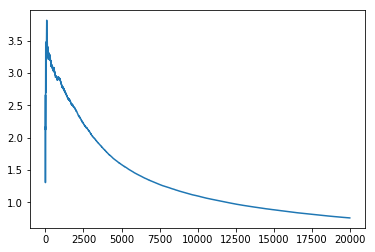

In [96]:
maml = SineModel()
train_maml(maml, 1, train_ds)

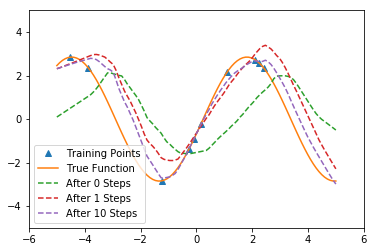

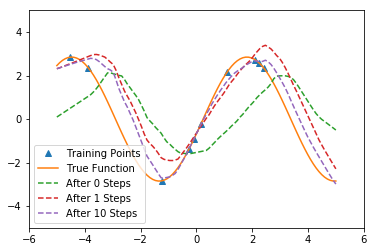

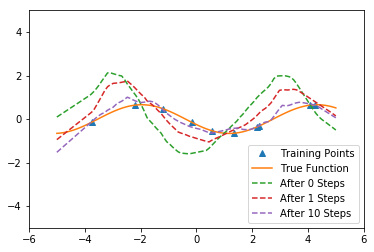

In [99]:
# Use MAML to fit new sine wave
for index in np.random.randint(0, len(test_ds), size=3):
    eval_sinewave_for_test(maml, test_ds[index])

In [100]:
# MAML vs Regular Network
def compare_maml_and_neural_net(maml, neural_net, sinusoid_generator, num_steps=list(range(10)),
                                intermediate_plot=True, marker='x', linestyle='--'):
    '''Compare the loss of a MAML model and a neural net.
    
    Fits the models for a new task (new sine wave) and then plot
    the loss of both models along `num_steps` interactions.
    
    Args:
        maml: An already trained MAML.
        neural_net: An already trained neural net.
        num_steps: Number of steps to be logged.
        intermediate_plot: If True plots intermediate plots from
            `eval_sinewave_for_test`.
        marker: Marker used for plotting.
        linestyle: Line style used for plotting.
    '''
    if intermediate_plot:
        print('MAML')
    fit_maml = eval_sinewave_for_test(maml, sinusoid_generator, plot=intermediate_plot)
    if intermediate_plot:
        print('Neural Net')
    fit_neural_net = eval_sinewave_for_test(neural_net, sinusoid_generator, plot=intermediate_plot)
    
    fit_res = {'MAML': fit_maml, 'Neural Net': fit_neural_net}
    
    legend = []
    for name in fit_res:
        x = []
        y = []
        for n, _, loss in fit_res[name]:
            x.append(n)
            y.append(loss)
        plt.plot(x, y, marker=marker, linestyle=linestyle)
        plt.xticks(num_steps)
        legend.append(name)
    plt.legend(legend)
    plt.show()

MAML


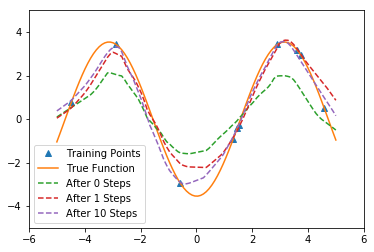

Neural Net


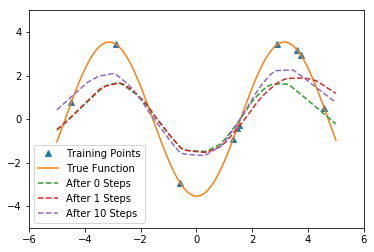

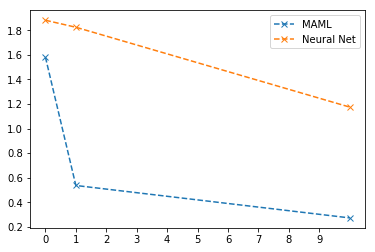

MAML


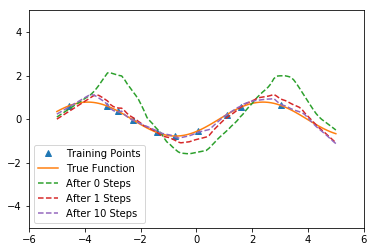

Neural Net


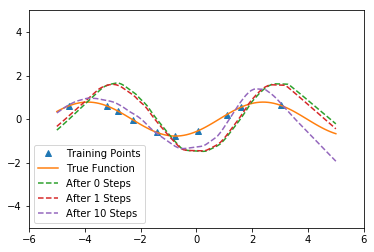

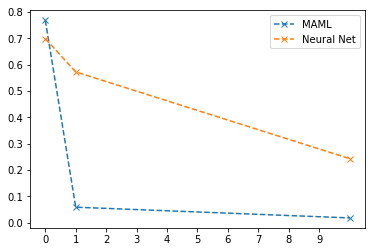

MAML


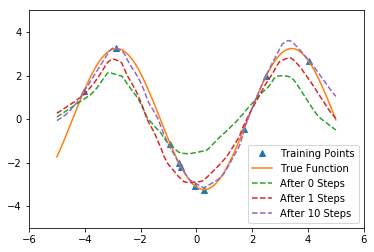

Neural Net


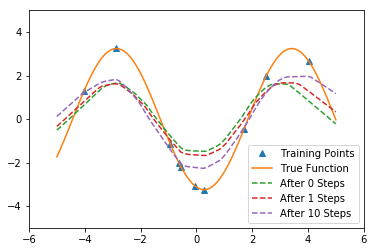

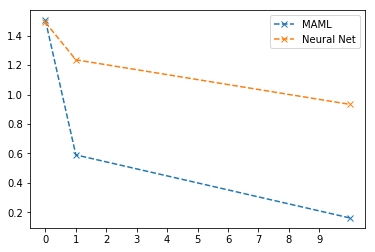

In [102]:
for _ in range(3):
    index = np.random.choice(range(len(test_ds)))
    compare_maml_and_neural_net(maml, neural_net, test_ds[index])